Auteur : MATHURIN Melvin & VOISIN Enzo ESIR2-SI

## IMPORTATION DES BIBLIOTHEQUES + METHODES UTILES

In [ ]:
#importation des bibliothèques
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import itertools

Fonction de comparaison de 2 chaines de caractères (Fonction de **levenshtein** permet de connaitre la "distance" entre 2 chaine de caractères)

In [ ]:
#le code de levenshtein (ressemblance de chaines de caractères)
def levenshtein(seq1, seq2):
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros((size_x, size_y))
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y
    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )
    return (matrix[size_x - 1, size_y - 1])

print("Score levenshtein entre \"Intel Core i5-9400\" et \"Intel Core i5-9400F\" est "+str(levenshtein("Intel Core i5-9400","Intel Core i5-9400F")))

Score levenshtein entre "Intel Core i5-9400" et "Intel Core i5-9400F" est 1.0


In [ ]:
levenshtein('money','ponet')

2.0

#RECUPERATION PAGE WEB TOPACHAT
Fonctions qui vont nous permettre de récupérer les données de chacun des composants en parcourant chaque page en classant les produits par ordre alphabétique

In [ ]:
# Fonction pour extraire les informations d'un produit
def get_topachat_products(url):
    # Récupération de la page web
    page = requests.get(url)
    # Analyse de la page web
    soup = BeautifulSoup(page.content, 'html.parser')
    # Récupération de tous les produits sur la page
    products = soup.find_all('div', class_='vue-recycle-scroller__item-view')
    # Extraction des informations pour chaque produit
    products_info = [{'Nom': p.find('h3', class_='pl-product__label').text.strip(), 
                      'Prix(€)': p.find('span', class_='offer-price__price offer-price__price--compact').text.strip(),
                      'Informations Supplementaires': p.find('div', class_='pl-product__sublabel').text.strip(),
                      'Reference url': 'https://www.topachat.com'+p.find('a', class_='product-list__product custom-link')['href']} for p in products]
    # Création d'un dataframe à partir des informations extraites
    df = pd.DataFrame(products_info)
    return df
#'Image':p.find('picture', class_='product-main-image pl-product__image').find('img')['src']
url = 'https://www.topachat.com/pages/produits_catalog_est_micro_puis_category_est_wpr_puis_ordre_est_A_puis_sens_est_ASC.html'
df = pd.DataFrame(get_topachat_products(url))

# Affichage du dataframe
#print(df['Image'][0])


In [ ]:
def recuperation_donnee_topachat(lien_url):
    liste_page = []
    page_topachat = requests.get(lien_url)
    soup_topachat = BeautifulSoup(page_topachat.text, "html.parser")
    liste_page.append(soup_topachat)
    numero_page = 2
    exception = True
    while(exception):
        try:
            page_topachat = requests.get(lien_url[:len(lien_url)-40]+"_puis_page_est_"+str(numero_page)+"_puis_ordre_est_L_puis_sens_est_ASC.html")
            soup_topachat = BeautifulSoup(page_topachat.text, "html.parser")
            if (soup_topachat.find('div', attrs = {'class' : 'pl-product pl-product--CCP'}).text.find("Désolé mais aucun article n’est actuellement disponible dans cette catégorie") == -1):
                liste_page.append(soup_topachat)
                numero_page +=1
            else:
                exception = False
        except ValueError:
            exception = False
    return liste_page

In [ ]:
#on recupere les articles avec tous les processeurs
def ajout_donnees_dataframe(liste_page, dataframe_topachat):
    compteur_article = 0
    for soup_topachat in liste_page:
        #basique
        article_topachat_NOR = soup_topachat.findAll('article', attrs = {'class' : 'grille-produit NOR'})
        #nouveauté
        article_topachat_NEW = soup_topachat.findAll('article', attrs = {'class' : 'grille-produit NEW'})
        #opération spéciale
        article_topachat_OPS = soup_topachat.findAll('article', attrs = {'class' : 'grille-produit OPS'})
        #remise
        article_topachat_CCP = soup_topachat.findAll('article', attrs = {'class' : 'grille-produit CCP'})
        for article in article_topachat_NOR:
            dataframe_topachat.loc[compteur_article] = [article.find('h3').text, float(article.find('div', attrs ={'class' : 'prod_px_euro v16'}).text[:len(article.find('div', attrs ={'class' : 'prod_px_euro v16'}).text)-2]), article.find('div', attrs ={'class' : 'small'}).text, "https://www.topachat.com"+article.find('a').get('href')] 
            compteur_article += 1
        for article in article_topachat_NEW:
            dataframe_topachat.loc[compteur_article] = [article.find('h3').text, float(article.find('div', attrs ={'class' : 'prod_px_euro v16'}).text[:len(article.find('div', attrs ={'class' : 'prod_px_euro v16'}).text)-2]), article.find('div', attrs ={'class' : 'small'}).text, "https://www.topachat.com"+article.find('a').get('href')] 
            compteur_article += 1
        for article in article_topachat_OPS:
            dataframe_topachat.loc[compteur_article] = [article.find('h3').text, float(article.find('div', attrs ={'class' : 'prod_px_euro v16'}).text[:len(article.find('div', attrs ={'class' : 'prod_px_euro v16'}).text)-2]), article.find('div', attrs ={'class' : 'small'}).text, "https://www.topachat.com"+article.find('a').get('href')] 
            compteur_article += 1
        for article in article_topachat_CCP:
            dataframe_topachat.loc[compteur_article] = [article.find('h3').text, float(article.find('div', attrs ={'class' : 'prod_px_euro v16'}).text[:len(article.find('div', attrs ={'class' : 'prod_px_euro v16'}).text)-3]), article.find('div', attrs ={'class' : 'small'}).text, "https://www.topachat.com"+article.find('a').get('href')] 
            compteur_article += 1


In [ ]:
def dataframe_unique(lien_url):
    liste_page = recuperation_donnee_topachat(lien_url)
    dataframe_topachat = pd.DataFrame(columns = ['Nom', 'Prix(€)', 'Informations Supplementaires', 'Reference url'])
    ajout_donnees_dataframe(liste_page, dataframe_topachat) 
    return dataframe_topachat

In [ ]:
def dataframe_donnee_unique(dataframe):
    nouveau = dataframe.copy()
    nouveau.drop_duplicates()
    
    return len(nouveau)==len(dataframe)

#Création des DataFrame pour chaque composants


### Elements principaux

**Processeurs**

In [ ]:
#Création du dataframe des processeurs et ajout
print("Début du chargement de la page des processeurs")
page_url_processeur = "https://www.topachat.com/pages/produits_cat_est_micro_puis_rubrique_est_wpr_puis_ordre_est_L_puis_sens_est_ASC.html"
dataframe_topachat_processeur = get_topachat_products(page_url_processeur)
dataframe_topachat_processeur['Prix(€)'] = dataframe_topachat_processeur['Prix(€)'].str.replace(r'[^\d.]+', '', regex=True).astype(float)
print(dataframe_topachat_processeur)
print("Les données sont elles uniques ? : "+str(dataframe_donnee_unique(dataframe_topachat_processeur)))
print("Fin de la page des processeurs\n")
#dataframe_topachat_processeur.to_csv('proc.csv', index = True)

Début du chargement de la page des processeurs
                                                  Nom  Prix(€)  \
0                         AMD Ryzen 3 3200G (3.6 GHz)   104.99   
1          AMD Ryzen 3 3200G (3.6 GHz) - Version Tray   102.99   
2                          AMD Ryzen 3 4100 (3.8 GHz)    92.99   
3           AMD Ryzen 3 4100 (3.8 GHz) - Version Bulk   114.99   
4                          AMD Ryzen 3 4300G (3.8GHz)   119.99   
5                         AMD Ryzen 5 3400G (3.7 GHz)   134.99   
6                          AMD Ryzen 5 3600 (3.6 GHz)    95.99   
7                          AMD Ryzen 5 4500 (3.6 GHz)   109.99   
8                         AMD Ryzen 5 4600G (3.7 GHz)   127.99   
9                          AMD Ryzen 5 5500 (3.6 GHz)   119.99   
10                         AMD Ryzen 5 5600 (3.5 GHz)   179.99   
11                        AMD Ryzen 5 5600G (3.9 GHz)   169.99   
12                        AMD Ryzen 5 5600X (3.7 GHz)   199.99   
13  AMD Ryzen 5 7600 (4.0 GHz

**Processeurs AMD**

In [ ]:
#Création du dataframe des processeurs AMD et ajout
print("Début du chargement de la page des processeurs d'AMD")
page_url_processeur_AMD = "https://www.topachat.com/pages/produits_cat_est_micro_puis_rubrique_est_wpr_puis_ordre_est_A_puis_sens_est_ASC_puis_marque_est_AMD.html"
dataframe_topachat_processeur_AMD = get_topachat_products(page_url_processeur_AMD)
dataframe_topachat_processeur_AMD['Prix(€)'] = dataframe_topachat_processeur_AMD['Prix(€)'].str.replace(r'[^\d.]+', '', regex=True).astype(float)
print(dataframe_topachat_processeur_AMD)
print("Les données sont elles uniques ? : "+str(dataframe_donnee_unique(dataframe_topachat_processeur_AMD)))
print("Fin de la page des processeurs AMD\n")

Début du chargement de la page des processeurs d'AMD
                                                  Nom  Prix(€)  \
0                         AMD Ryzen 3 3200G (3.6 GHz)   104.99   
1          AMD Ryzen 3 3200G (3.6 GHz) - Version Tray   102.99   
2                          AMD Ryzen 3 4100 (3.8 GHz)    92.99   
3           AMD Ryzen 3 4100 (3.8 GHz) - Version Bulk   114.99   
4                          AMD Ryzen 3 4300G (3.8GHz)   119.99   
5                         AMD Ryzen 5 3400G (3.7 GHz)   134.99   
6                          AMD Ryzen 5 3600 (3.6 GHz)    95.99   
7                          AMD Ryzen 5 4500 (3.6 GHz)   109.99   
8                         AMD Ryzen 5 4600G (3.7 GHz)   127.99   
9                          AMD Ryzen 5 5500 (3.6 GHz)   119.99   
10                         AMD Ryzen 5 5600 (3.5 GHz)   179.99   
11                        AMD Ryzen 5 5600G (3.9 GHz)   169.99   
12                        AMD Ryzen 5 5600X (3.7 GHz)   199.99   
13  AMD Ryzen 5 7600 (4

**Processeur Intel**

In [ ]:
#Création du dataframe des processeurs INTEL et ajout
print("Début du chargement de la page des processeurs INTEL")
page_url_processeur_INTEL = "https://www.topachat.com/pages/produits_cat_est_micro_puis_rubrique_est_wpr_puis_ordre_est_A_puis_sens_est_ASC_puis_marque_est_INTEL.html"
dataframe_topachat_processeur_INTEL = get_topachat_products(page_url_processeur_INTEL)
dataframe_topachat_processeur_INTEL['Prix(€)'] = dataframe_topachat_processeur_INTEL['Prix(€)'].str.replace(r'[^\d.]+', '', regex=True).astype(float)
print(dataframe_topachat_processeur_INTEL)
print("Les données sont elles uniques ? : "+str(dataframe_donnee_unique(dataframe_topachat_processeur_INTEL)))
print("Fin de la page des processeurs INTEL\n")

Début du chargement de la page des processeurs INTEL
                                    Nom  Prix(€)  \
0         Intel Celeron G5905 (3.5 GHz)    49.99   
1         Intel Celeron G5925 (3.6 GHz)    54.99   
2         Intel Celeron G6900 (3.4 GHz)    76.99   
3         Intel Core i3-10100 (3.6 GHz)   119.99   
4        Intel Core i3-10100F (3.6 GHz)    87.99   
5         Intel Core i3-10105 (3.7 GHz)   124.99   
6        Intel Core i3-10105F (3.7 GHz)    89.99   
7         Intel Core i3-12100 (3.3 GHz)   159.99   
8        Intel Core i3-12100F (3.3 GHz)   114.99   
9         Intel Core i3-13100 (3.4 GHz)   179.99   
10       Intel Core i3-13100F (3.4 GHz)   139.99   
11        Intel Core i5-10400 (2.9 GHz)   139.99   
12       Intel Core i5-10400F (2.9 GHz)   114.99   
13        Intel Core i5-10500 (3.1 GHz)   234.99   
14        Intel Core i5-11400 (2.6 GHz)   174.99   
15       Intel Core i5-11400F (2.6 GHz)   149.99   
16        Intel Core i5-11500 (2.7 GHz)   265.99   
17        I

**Carte Graphique**

In [ ]:
#Création du dataframe des cartes graphiques et ajout
print("Début du chargement de la page des cartes graphiques")
page_url_cartegraphique = "https://www.topachat.com/pages/produits_cat_est_micro_puis_rubrique_est_wgfx_pcie_puis_ordre_est_L_puis_sens_est_ASC.html"
dataframe_topachat_cartegraphique = get_topachat_products(page_url_cartegraphique)
dataframe_topachat_cartegraphique['Prix(€)'] = dataframe_topachat_cartegraphique['Prix(€)'].str.replace(r'[^\d.]+', '', regex=True).astype(float)
print(dataframe_topachat_cartegraphique)
print("Les données sont elles uniques ? : "+str(dataframe_donnee_unique(dataframe_topachat_cartegraphique)))
print("Fin de la page des cartes graphiques\n")
#dataframe_topachat_cartegraphique.to_csv('carteGraphique.csv', index = True)

Début du chargement de la page des cartes graphiques
                                                  Nom  Prix(€)  \
0   AMD Radeon RX 6950 XT + The Last of Us Part 1 ...   699.99   
1   AORUS GeForce RTX 4070 MASTER + Diablo IV offe...   849.99   
2   AORUS GeForce RTX 4070 Ti ELITE + Diablo IV of...  1099.99   
3   AORUS GeForce RTX 4070 Ti MASTER + Diablo IV o...  1159.99   
4   AORUS GeForce RTX 4080 MASTER + Diablo IV offe...  1599.99   
5   AORUS GeForce RTX 4080 XTREME WATERFORCE + Dia...  1789.99   
6   AORUS GeForce RTX 4080 XTREME WATERFORCE WB + ...  1649.99   
7   AORUS GeForce RTX 4090 MASTER 24G + Diablo IV ...  2199.99   
8   AORUS GeForce RTX 4090 XTREME WATERFORCE + Dia...  2299.99   
9   AORUS Radeon RX 7900 XTX ELITE 24G + The Last ...  1249.99   
10  ASRock Radeon RX 6600 Challenger D OC + The La...   229.99   
11                     Asus GeForce GT 1030 SL-2G-BRK   109.99   
12                Asus GeForce GT 710 DDR3 EVO (2 Go)    59.99   
13              Asus Ge

**Boitier**

In [ ]:
#Création du dataframe des boitiers et ajout
print("Début du chargement de la page des boitiers")
page_url_boitier = "https://www.topachat.com/pages/produits_cat_est_micro_puis_rubrique_est_w_boi_sa_puis_ordre_est_L_puis_sens_est_ASC.html"  
dataframe_topachat_boitier = get_topachat_products(page_url_boitier)
dataframe_topachat_boitier['Prix(€)'] = dataframe_topachat_boitier['Prix(€)'].str.replace(r'[^\d.]+', '', regex=True).astype(float)
print(dataframe_topachat_boitier)
print("Les données sont elles uniques ? : "+str(dataframe_donnee_unique(dataframe_topachat_boitier)))
print("Fin de la page des boitiers\n")
#dataframe_topachat_boitier.to_csv('boitier.csv', index = True)

Début du chargement de la page des boitiers
                                                  Nom  Prix(€)  \
0                             Aerocool Atomic Lite V2    79.99   
1                               Aerocool Blade - Noir    59.99   
2                           Aerocool Bolt Mini - Noir    59.99   
3                            Aerocool Bolt RGB - Noir    39.99   
4                                     Aerocool CS-106    34.99   
5                                Aerocool CS-107-A V2    44.99   
6                         Aerocool Cylon Mini - Blanc    44.99   
7                          Aerocool Cylon Mini - Noir    44.99   
8                      Aerocool Cylon Pro RGB - Blanc    69.99   
9                       Aerocool Cylon Pro RGB - Noir    69.99   
10                         Aerocool Cylon RGB - Blanc    54.99   
11                          Aerocool Cylon RGB - Noir    54.99   
12                             Aerocool Graphite ARGB    94.99   
13                              

**SSD**

In [ ]:
#Création du dataframe des SSD et ajout
print("Début du chargement de la page des SSD")
page_url_ssd = "https://www.topachat.com/pages/produits_cat_est_micro_puis_rubrique_est_w_ssd_puis_ordre_est_L_puis_sens_est_ASC.html"
dataframe_topachat_ssd = get_topachat_products(page_url_ssd)
dataframe_topachat_ssd['Prix(€)'] = dataframe_topachat_ssd['Prix(€)'].str.replace(r'[^\d.]+', '', regex=True).astype(float)
print(dataframe_topachat_ssd)
print("Les données sont elles uniques ? : "+str(dataframe_donnee_unique(dataframe_topachat_ssd)))
print("Fin de la page des SSD\n")
#dataframe_topachat_ssd.to_csv('ssd.csv', index = True)

Début du chargement de la page des SSD
                                    Nom  Prix(€)  \
0           Corsair Force MP510 1.92 To   199.99   
1         Corsair Force MP510 V2 480 Go    77.99   
2              Corsair Force MP600 1 To   119.99   
3     Corsair Force MP600 2 To (Rev. 2)   209.99   
4            Corsair Force MP600 500 Go   127.99   
5   Corsair Force MP600 500 Go (Rev. 2)    89.99   
6           Corsair Force MP600 GS 1 To    94.99   
7           Corsair Force MP600 GS 2 To   174.99   
8         Corsair Force MP600 GS 500 Go    62.99   
9               Corsair MP600 Core 2 To   309.99   
10           Corsair MP600 CORE XT 1 To    69.99   
11           Corsair MP600 CORE XT 2 To   129.99   
12           Corsair MP600 CORE XT 4 To   339.99   
13               Corsair MP600 Pro 1 To   139.99   
14               Corsair MP600 Pro 4 To   899.99   
15           Corsair MP600 Pro LPX 2 To   249.99   
16         Corsair MP600 Pro LPX 500 Go   113.99   
17            Corsair MP6

**HDD**

In [ ]:
#Création du dataframe des HDD et ajout
print("Début du chargement de la page des HDD")
page_url_hdd = "https://www.topachat.com/pages/produits_cat_est_micro_puis_rubrique_est_wdi_sata_puis_ordre_est_L_puis_sens_est_ASC.html"
dataframe_topachat_hdd = get_topachat_products(page_url_hdd)
dataframe_topachat_hdd['Prix(€)'] = dataframe_topachat_hdd['Prix(€)'].str.replace(r'[^\d.]+', '', regex=True).astype(float)
print(dataframe_topachat_hdd)
print("Les données sont elles uniques ? : "+str(dataframe_donnee_unique(dataframe_topachat_hdd)))
print("Fin de la page des HDD\n")
#dataframe_topachat_hdd.to_csv('hdd.csv', index = True)

Début du chargement de la page des HDD
                               Nom  Prix(€)  \
0           Seagate BarraCuda 1 To    40.99   
1           Seagate BarraCuda 2 To    59.99   
2           Seagate BarraCuda 2 To    54.99   
3           Seagate BarraCuda 3 To    86.99   
4           Seagate BarraCuda 4 To    89.99   
5           Seagate BarraCuda 6 To   129.99   
6           Seagate BarraCuda 8 To   139.99   
7            Seagate Exos 7E8 2 To   139.99   
8            Seagate Exos 7E8 4 To   164.99   
9            Seagate Exos 7E8 6 To   229.99   
10           Seagate Exos 7E8 8 To   249.99   
11          Seagate Exos X20 20 To   409.99   
12       Seagate FireCuda HDD 8 To   245.99   
13           Seagate IronWolf 1 To    59.99   
14          Seagate IronWolf 10 To   289.99   
15          Seagate IronWolf 12 To   279.99   
16           Seagate IronWolf 2 To    87.99   
17           Seagate IronWolf 3 To    99.99   
18           Seagate IronWolf 4 To    99.99   
19           Seagate 

**RAM DDR4**

In [ ]:
#Création du dataframe des DDR4 et ajout
print("Début du chargement de la page des DDR4")
page_url_DDR4 = "https://www.topachat.com/pages/produits_cat_est_micro_puis_rubrique_est_wme_ddr4_puis_ordre_est_L_puis_sens_est_ASC.html"
dataframe_topachat_DDR4 = get_topachat_products(page_url_DDR4)
dataframe_topachat_DDR4['Prix(€)'] = dataframe_topachat_DDR4['Prix(€)'].str.replace(r'[^\d.]+', '', regex=True).astype(float)
print(dataframe_topachat_DDR4)
print("Les données sont elles uniques ? : "+str(dataframe_donnee_unique(dataframe_topachat_DDR4)))
print("Fin de la page des DDR4\n")
#dataframe_topachat_DDR4.to_csv('ram.csv', index = True)

Début du chargement de la page des DDR4
                                                  Nom  Prix(€)  \
0   Corsair Vengeance RGB PRO - Blanc (kit d'éclai...    40.49   
1   Corsair Vengeance RGB PRO - Noir (kit d'éclair...    39.99   
2   DDR4 Corsair Dominator Platinum - 32 Go (2 x 1...   192.57   
3   DDR4 Corsair Dominator Platinum RGB - 128 Go (...   673.60   
4   DDR4 Corsair Dominator Platinum RGB - 16 Go (2...   113.54   
5   DDR4 Corsair Dominator Platinum RGB - 16 Go (2...   124.52   
6   DDR4 Corsair Dominator Platinum RGB - 16 Go (2...   132.35   
7   DDR4 Corsair Dominator Platinum RGB - 16 Go (2...   206.79   
8   DDR4 Corsair Dominator Platinum RGB - 16 Go (2...   193.85   
9   DDR4 Corsair Dominator Platinum RGB - 32 Go (2...   176.30   
10  DDR4 Corsair Dominator Platinum RGB - 32 Go (2...   175.90   
11  DDR4 Corsair Dominator Platinum RGB - 32 Go (2...   174.52   
12  DDR4 Corsair Dominator Platinum RGB - 32 Go (2...   180.37   
13  DDR4 Corsair Dominator Platinum 

**RAM DDR3**

In [ ]:
#Création du dataframe des DDR3 et ajout
print("Début du chargement de la page des DDR3")
page_url_DDR3 = "https://www.topachat.com/pages/produits_cat_est_micro_puis_rubrique_est_wme_ddr3_puis_ordre_est_L_puis_sens_est_ASC.html"
dataframe_topachat_DDR3 = get_topachat_products(page_url_DDR3)
dataframe_topachat_DDR3['Prix(€)'] = dataframe_topachat_DDR3['Prix(€)'].str.replace(r'[^\d.]+', '', regex=True).astype(float)
print(dataframe_topachat_DDR3)
print("Les données sont elles uniques ? : "+str(dataframe_donnee_unique(dataframe_topachat_DDR3)))
print("Fin de la page des DDR3\n")

Début du chargement de la page des DDR3
                                                  Nom  Prix(€)  \
0         DDR3 Corsair Value - 4 Go 1600 MHz - CAS 11    31.32   
1   DDR3 Corsair Value Select - 4 Go 1333 MHz - CAS 9    32.65   
2   DDR3 Corsair Value Select - 8 Go (2 x 4 Go) 13...    59.53   
3   DDR3 Corsair Value Select - 8 Go 1333 MHz - CAS 9    52.05   
4   DDR3 Corsair Vengeance - 12 Go (3 x 4 Go) 1600...   108.47   
5   DDR3 Corsair Vengeance - 16 Go (2 x 8 Go) 1600...   122.45   
6     DDR3 Corsair Vengeance - 8 Go 1600 MHz - CAS 10    57.91   
7   DDR3 Corsair Vengeance Low Profile - 16 Go (2 ...   107.41   
8   DDR3 Corsair Vengeance Low Profile - 8 Go - 16...    56.30   
9   DDR3 Corsair Vengeance Low Profile - 8 Go (2 x...    76.33   
10  DDR3 Corsair XMS3 - 8 Go (2 x 4 Go) 1333 MHz -...    69.08   
11  DDR3 G.Skill Aegis - 16 Go (2 x 8 Go) 1600 MHz...    44.99   
12         DDR3 G.Skill Aegis - 4 Go 1333 MHz - CAS 9    15.84   
13        DDR3 G.Skill Aegis - 4 Go 

**RAM DDR5**

In [ ]:
#Création du dataframe des DDR5 et ajout
print("Début du chargement de la page des DDR5")
page_url_DDR5 = "https://www.topachat.com/pages/produits_cat_est_micro_puis_rubrique_est_wme_ddr5_puis_ordre_est_A_puis_sens_est_ASC.html"
dataframe_topachat_DDR5 = get_topachat_products(page_url_DDR5)
dataframe_topachat_DDR5['Prix(€)'] = dataframe_topachat_DDR5['Prix(€)'].str.replace(r'[^\d.]+', '', regex=True).astype(float)
print(dataframe_topachat_DDR5)
print("Les données sont elles uniques ? : "+str(dataframe_donnee_unique(dataframe_topachat_DDR5)))
print("Fin de la page des DDR5\n")

Début du chargement de la page des DDR5
                                                  Nom  Prix(€)  \
0   DDR5 Corsair Dominator Platinum - 32 Go (2 x 1...   440.99   
1   DDR5 Corsair Dominator Platinum Blanc - 32 Go ...   210.42   
2   DDR5 Corsair Dominator Platinum RGB - 32 Go (2...   246.45   
3   DDR5 Corsair Dominator Platinum RGB - 32 Go (2...   206.99   
4   DDR5 Corsair Dominator Platinum RGB - 32 Go (2...   237.10   
5   DDR5 Corsair Dominator Platinum RGB - 32 Go (2...   229.49   
6   DDR5 Corsair Dominator Platinum RGB - 32 Go (2...   261.56   
7   DDR5 Corsair Dominator Platinum RGB - 32 Go (2...   215.99   
8   DDR5 Corsair Dominator Platinum RGB - 32 Go (2...   269.99   
9   DDR5 Corsair Dominator Platinum RGB - 32 Go (2...   224.99   
10  DDR5 Corsair Dominator Platinum RGB - 32 Go (2...   269.99   
11  DDR5 Corsair Dominator Platinum RGB - 32 Go (2...   293.46   
12  DDR5 Corsair Dominator Platinum RGB - 64  Go (...   421.43   
13  DDR5 Corsair Dominator Platinum 

**Carte mère 1700**

In [ ]:
#Création du dataframe des 1700 et ajout
print("Début du chargement de la page des 1700")
page_url_1151 = "https://www.topachat.com/pages/produits_cat_est_micro_puis_rubrique_est_w_cm_1700_puis_ordre_est_A_puis_sens_est_ASC.html"
dataframe_topachat_1700 = get_topachat_products(page_url_1151)
dataframe_topachat_1700['Prix(€)'] = dataframe_topachat_1700['Prix(€)'].str.replace(r'[^\d.]+', '', regex=True).astype(float)
print(dataframe_topachat_1700)
print("Les données sont elles uniques ? : "+str(dataframe_donnee_unique(dataframe_topachat_1700)))
print("Fin de la page des 1700\n")

Début du chargement de la page des 1700
                                   Nom  Prix(€)  \
0             ASRock B660M Pro RS DDR4   139.99   
1       ASRock B660M Steel Legend DDR4   164.99   
2                ASRock B660M-HDV DDR4   114.99   
3                   ASRock B760 Pro RS   189.99   
4              ASRock B760 Pro RS DDR4   169.99   
5              ASRock B760M PG Riptide   164.99   
6           ASRock B760M PG SONIC WIFI   199.99   
7                  ASRock B760M PRO RS   149.99   
8             ASRock B760M Pro RS DDR4   149.99   
9        ASRock B760M Pro RS DDR4 WIFI   174.99   
10      ASRock B760M Steel Legend WIFI   189.99   
11           ASRock B760M-HDV/M.2 DDR4   129.99   
12          ASRock B760M-ITX WIFI DDR4   189.99   
13               ASRock H610M-HDV DDR4    94.99   
14           ASROCK H610M-HDV/M.2 DDR4   106.99   
15               ASRock H610M-HVS DDR4    92.99   
16            ASRock H610M-ITX/AC DDR4   169.99   
17         ASRock H670 PG Riptide DDR4   1

**Carte mère 1200**

In [ ]:
#Création du dataframe des 1200 et ajout
print("Début du chargement de la page des 1200")
page_url_1200 = "https://www.topachat.com/pages/produits_cat_est_micro_puis_rubrique_est_w_cm_1200_puis_ordre_est_L_puis_sens_est_ASC.html"
dataframe_topachat_1200 = get_topachat_products(page_url_1200)
dataframe_topachat_1200['Prix(€)'] = dataframe_topachat_1200['Prix(€)'].str.replace(r'[^\d.]+', '', regex=True).astype(float)
print(dataframe_topachat_1200)
print("Les données sont elles uniques ? : "+str(dataframe_donnee_unique(dataframe_topachat_1200)))
print("Fin de la page des 1200\n")

Début du chargement de la page des 1200
                                                 Nom  Prix(€)  \
0                                ASRock H510M-ITX/AC   109.99   
1                                 Asus PRIME H510M-E    90.99   
2  Asus ROG STRIX Z590-E GAMING WIFI + ROG RYUO -...   549.99   
3                  Asus ROG STRIX Z590-F GAMING WIFI   243.99   
4                                   GIGABYTE H510M H    82.99   
5                                    MSI B560M PRO-E    92.99   
6                                     MSI Z590-A PRO   164.99   
7                               NZXT N7 Z590 - Blanc   299.99   
8                                NZXT N7 Z590 - Noir   289.99   

                        Informations Supplementaires  \
0  Carte mère Mini-ITX - Socket 1200 - Chipset In...   
1  Carte mère mATX - Socket 1200 - Chipset Intel ...   
2  Carte mère ATX - Socket 1200 - Chipset Intel Z...   
3  Carte mère ATX - Socket 1200 - Chipset Intel Z...   
4  Carte mère mATX - Socket 1

**Carte mère AM4**

In [ ]:
#Création du dataframe des AM4 et ajout
print("Début du chargement de la page des AM4")
page_url_AM4 = "https://www.topachat.com/pages/produits_cat_est_micro_puis_rubrique_est_w_cm_am4_puis_ordre_est_L_puis_sens_est_ASC.html"
dataframe_topachat_AM4 = get_topachat_products(page_url_AM4)
dataframe_topachat_AM4['Prix(€)'] = dataframe_topachat_AM4['Prix(€)'].str.replace(r'[^\d.]+', '', regex=True).astype(float)
print(dataframe_topachat_AM4)
print("Les données sont elles uniques ? : "+str(dataframe_donnee_unique(dataframe_topachat_AM4)))
print("Fin de la page des AM4\n")

Début du chargement de la page des AM4
                                     Nom  Prix(€)  \
0          ASRock A520M Phantom Gaming 4    89.99   
1               ASRock B450 Steel Legend   114.99   
2                 ASRock B450M PRO4 R2.0    94.99   
3                   ASRock B550 EXTREME4   199.99   
4                 ASRock B550 PG RIPTIDE   159.99   
5           ASRock B550 Phantom Gaming 4   129.99   
6      ASRock B550 Phantom Gaming-ITX/AX   209.99   
7                       ASRock B550 Pro4   144.99   
8               ASRock B550 Steel Legend   159.99   
9                     ASRock B550 Taichi   329.99   
10      ASRock B550 Taichi Razer Edition   364.99   
11               ASRock B550M PG Riptide   129.99   
12         ASRock B550M Phantom Gaming 4   102.99   
13                     ASRock B550M Pro4   119.99   
14             ASRock B550M Steel Legend   139.99   
15                      ASRock B550M-HDV    87.99   
16                   ASRock B550M-ITX/AC   154.99   
17     

**Carte mère 2066**

In [ ]:
#Création du dataframe des 2066 et ajout
print("Début du chargement de la page des 2066")
page_url_2066 = "https://www.topachat.com/pages/produits_cat_est_micro_puis_rubrique_est_w_cm_2066_puis_ordre_est_L_puis_sens_est_ASC.html"
dataframe_topachat_2066 = get_topachat_products(page_url_2066)
dataframe_topachat_2066['Prix(€)'] = dataframe_topachat_2066['Prix(€)'].str.replace(r'[^\d.]+', '', regex=True).astype(float)
print(dataframe_topachat_2066)
print("Les données sont elles uniques ? : "+str(dataframe_donnee_unique(dataframe_topachat_2066)))
print("Fin de la page des 2066\n")

Début du chargement de la page des 2066
                               Nom  Prix(€)  \
0              ASRock X299 Creator   539.99   
1         ASRock X299 Steel Legend   309.99   
2             Asus PRIME X299-A II   419.99   
3  Asus ROG STRIX X299-E GAMING II   489.99   

                        Informations Supplementaires  \
0  Carte mère ATX - Socket 2066 - Chipset Intel X...   
1  Carte mère ATX - Socket 2066 - Chipset Intel X...   
2  Carte mère ATX - Socket 2066 - Chipset Intel X...   
3  Carte mère ATX - Socket 2066 - Chipset Intel X...   

                                       Reference url  
0  https://www.topachat.com/pages/detail2_cat_est...  
1  https://www.topachat.com/pages/detail2_cat_est...  
2  https://www.topachat.com/pages/detail2_cat_est...  
3  https://www.topachat.com/pages/detail2_cat_est...  
Les données sont elles uniques ? : True
Fin de la page des 2066



**Alimentation**

In [ ]:
#Création du dataframe des alimentations et ajout
print("Début du chargement de la page des Alimentations")
page_url_alimentation = "https://www.topachat.com/pages/produits_cat_est_micro_puis_rubrique_est_w_ali_puis_ordre_est_A_puis_sens_est_ASC.html"
dataframe_topachat_alimentation = get_topachat_products(page_url_alimentation)
dataframe_topachat_alimentation['Prix(€)'] = dataframe_topachat_alimentation['Prix(€)'].str.replace(r'[^\d.]+', '', regex=True).astype(float)
print(dataframe_topachat_alimentation)
print("Les données sont elles uniques ? : "+str(dataframe_donnee_unique(dataframe_topachat_alimentation)))
print("Fin de la page des Alimentations\n")
#dataframe_topachat_alimentation.to_csv('alim.csv', index = True)

Début du chargement de la page des Alimentations
                                              Nom  Prix(€)  \
0                        Aerocool Lux 550W - 550W    44.99   
1                        Aerocool Lux 650W - 650W    49.99   
2                       Aerocool Lux 750W - 750 W    59.99   
3                        Aerocool Lux 850W - 850W    74.99   
4                    Aerocool Lux RGB 550M - 550W    54.99   
5                    Aerocool Lux RGB 650M - 650W    64.99   
6                    Aerocool Lux RGB 750M - 750W    74.99   
7                    Aerocool Lux RGB 850M - 850W    84.99   
8                      Antec HCG1000 Gold - 1000W   199.99   
9                           Antec NeoECO NE750G M   109.99   
10                   Antec NeoECO NE850G M - 850W   124.99   
11               Antec Signature Platinum - 1000W   229.99   
12               Antec Signature Titanium - 1000W   249.99   
13                    Asus ROG Loki SFX-L - 1000W   289.99   
14                   

**Watercooling**

In [ ]:
#Création du dataframe des watercooling et ajout
print("Début du chargement de la page des watercoolings")
page_url_watercooling = "https://www.topachat.com/pages/produits_cat_est_micro_puis_rubrique_est_w_reliq_puis_ordre_est_L_puis_sens_est_ASC.html"
dataframe_topachat_watercooling = get_topachat_products(page_url_watercooling)
dataframe_topachat_watercooling['Prix(€)'] = dataframe_topachat_watercooling['Prix(€)'].str.replace(r'[^\d.]+', '', regex=True).astype(float)
print(dataframe_topachat_watercooling)
print("Les données sont elles uniques ? : "+str(dataframe_donnee_unique(dataframe_topachat_watercooling)))
print("Fin de la page des watercoolings\n")
#dataframe_topachat_watercooling.to_csv('watercooling.csv', index = True)

Début du chargement de la page des watercoolings
                                                  Nom  Prix(€)  \
0                       Aerocool Mirage L120 - 120 mm    79.99   
1                       Aerocool Mirage L240 - 240 mm   104.99   
2                 Aerocool Mirage L240 Blanc - 240 mm   104.99   
3                       Aerocool Mirage L360 - 360 mm   124.99   
4                 Aerocool Mirage L360 Blanc - 360 mm   124.99   
5                             Antec Symphony 240 ARGB    89.99   
6                             Antec Symphony 360 ARGB   114.99   
7                      Antec Vortex 240 ARGB - 240 mm    99.99   
8                      Antec Vortex 360 ARGB - 360 mm   129.99   
9               Arctic Liquid Freezer II 240 - 240 mm    99.99   
10        Arctic Liquid Freezer II 240 A-RGB - 240 mm   117.99   
11  Arctic Liquid Freezer II 240 RGB - 240 mm + Co...   119.99   
12              Arctic Liquid Freezer II 280 - 280 mm   104.99   
13        Arctic Liquid Fre

**Aircooling et Ventirad**

In [ ]:
#Création du dataframe des aircooling/ventirad et ajout
print("Début du chargement de la page des aircoolings")
page_url_aircooling = "https://www.topachat.com/pages/produits_cat_est_micro_puis_rubrique_est_w_ven_puis_ordre_est_L_puis_sens_est_ASC.html"
dataframe_topachat_aircooling = get_topachat_products(page_url_aircooling)
dataframe_topachat_aircooling['Prix(€)'] = dataframe_topachat_aircooling['Prix(€)'].str.replace(r'[^\d.]+', '', regex=True).astype(float)
print(dataframe_topachat_aircooling)
print("Les données sont elles uniques ? : "+str(dataframe_donnee_unique(dataframe_topachat_aircooling)))
print("Fin de la page des aircoolings\n")
#dataframe_topachat_aircooling.to_csv('aircooling.csv', index = True)

Début du chargement de la page des aircoolings
                                                  Nom  Prix(€)  \
0                                  Aerocool Core Plus    14.99   
1                                   Aerocool Cylon 3H    39.99   
2                                    Aerocool Cylon 4    39.99   
3                            Aerocool Cylon 4 - Blanc    42.99   
4                                   Aerocool Mirage 5    44.99   
5                                Akasa Alucia H4 Plus    49.99   
6                                  Akasa Soho H4 Plus    69.99   
7                                    AMD Wraith Prism    39.99   
8                                    AMD Wraith Spire    14.99   
9                                           Antec A30    16.99   
10                                      Antec A40 Pro    24.99   
11                                    Antec A400i RGB    36.99   
12                                         Antec C400    39.99   
13                           

**Pates Thermique**

In [ ]:
#Création du dataframe des pates thermiques et ajout
print("Début du chargement de la page des pates thermiques")
page_url_patethermique = "https://www.topachat.com/pages/produits_cat_est_micro_puis_rubrique_est_w_path_puis_ordre_est_L_puis_sens_est_ASC.html"
dataframe_topachat_patethermique = get_topachat_products(page_url_patethermique)
dataframe_topachat_patethermique['Prix(€)'] = dataframe_topachat_patethermique['Prix(€)'].str.replace(r'[^\d.]+', '', regex=True).astype(float)
print(dataframe_topachat_patethermique)
print("Les données sont elles uniques ? : "+str(dataframe_donnee_unique(dataframe_topachat_patethermique)))
print("Fin de la page des pates thermiques\n")
#dataframe_topachat_patethermique.to_csv('pate.csv', index = True)

Début du chargement de la page des pates thermiques
                                                  Nom  Prix(€)  \
0                                Aerocool Baraf - 1 g     4.99   
1                                  Aerocool Cog - 2 g     4.99   
2                                  Aerocool Cog - 4 g    12.99   
3          Akasa AK-455 (5 g) + Lingettes nettoyantes    12.99   
4                               Akasa AK-455-2G - 2 g     5.99   
5                                     Akasa AK-TCW-02     8.99   
6                           Arctic Cooling MX-4 - 4 g     9.99   
7                                   Arctic MX-4 - 2 g     7.99   
8                                  Arctic MX-4 - 20 g    23.99   
9                                   Arctic MX-4 - 4 g     8.99   
10                                 Arctic MX-4 - 45 g    44.99   
11                                  Arctic MX-4 - 8 g    11.99   
12                                  Arctic MX-6 - 2 g     7.99   
13                      

###Accesoires
**Ecran**

In [ ]:
#Création du dataframe des ecrans et ajout
print("Début du chargement de la page des écrans")
page_url_screen = "https://www.topachat.com/pages/produits_cat_est_peripheriques_puis_rubrique_est_w_moni_puis_ordre_est_A_puis_sens_est_ASC.html"
dataframe_topachat_ecran = get_topachat_products(page_url_screen)
dataframe_topachat_ecran['Prix(€)'] = dataframe_topachat_ecran['Prix(€)'].str.replace(r'[^\d.]+', '', regex=True).astype(float)
print(dataframe_topachat_ecran)
print("Les données sont elles uniques ? : "+str(dataframe_donnee_unique(dataframe_topachat_ecran)))
print("Fin de la page des écrans\n")
#dataframe_topachat_ecran.to_csv('screen.csv', index = True)

Début du chargement de la page des écrans
                                                  Nom  Prix(€)  \
0                                    Acer B227QBMIPRX   144.95   
1                                    Acer B277bmiprzx   229.99   
2                          Acer CB242Ybmiprx FreeSync   169.99   
3                                Acer CB273UBEMIPRUZX   329.99   
4     Acer ED270Xbiipx Adaptive Sync (dalle incurvée)   224.99   
5                   Acer Nitro VG240YSbmiipx FreeSync   184.99   
6                    Acer Nitro VG270Sbmiipx FreeSync   239.99   
7            Acer Nitro XV253QPbmiiprzx Adaptive Sync   229.99   
8                Acer Nitro XV272UXbmiipruzx FreeSync   669.99   
9             Acer Nitro XV273Xbmiiprzx Adaptive Sync   369.99   
10  Acer Nitro XZ322QUPbmiiphx FreeSync (dalle inc...   429.99   
11                                    Acer V227QBMIPX   139.99   
12                      Acer V247Ybmipx Adaptive Sync   174.99   
13                           Alien

**Casques**

In [ ]:
#Création du dataframe des casques et ajout
print("Début du chargement de la page des casques")
page_url_casque = "https://www.topachat.com/pages/produits_cat_est_gaming_puis_rubrique_est_wg_pccas_puis_ordre_est_A_puis_sens_est_ASC.html"
dataframe_topachat_casque = get_topachat_products(page_url_casque)
dataframe_topachat_casque['Prix(€)'] = dataframe_topachat_casque['Prix(€)'].str.replace(r'[^\d.]+', '', regex=True).astype(float)
print(dataframe_topachat_casque)
print("Les données sont elles uniques ? : "+str(dataframe_donnee_unique(dataframe_topachat_casque)))
print("Fin de la page des casques\n")
#dataframe_topachat_casque.to_csv('casque.csv', index = True)

Début du chargement de la page des casques
                                                  Nom  Prix(€)  \
0                                     Advance GTA 210    16.99   
1                                  Antlion Kimura Duo   179.99   
2                                 Antlion Kimura Solo   119.99   
3                                   AOC GH300 USB 7.1    64.99   
4                              Astro A10 Call of Duty    64.99   
5                      Astro A10 Gris (2e Génération)    59.99   
6                              Astro A10 Gris / Rouge    49.99   
7                                 Astro A10 Gris/Bleu    49.99   
8                                 Astro A10 Gris/Vert    64.99   
9                     Astro A10 Lilas (2e Génération)    59.99   
10        Astro A10 PlayStation Blanc (2e Génération)    59.99   
11         Astro A10 PlayStation Noir (2e Génération)    59.99   
12               Astro A10 Xbox Blanc (2e Génération)    59.99   
13                Astro A10 Xbox 

**Clavier**

In [ ]:
#Création du dataframe des claviers et ajout
print("Début du chargement de la page des claviers")
page_url_claviers = "https://www.topachat.com/pages/produits_cat_est_gaming_puis_rubrique_est_wg_pccla_puis_ordre_est_A_puis_sens_est_ASC.html"
dataframe_topachat_claviers = get_topachat_products(page_url_claviers)
dataframe_topachat_claviers['Prix(€)'] = dataframe_topachat_claviers['Prix(€)'].str.replace(r'[^\d.]+', '', regex=True).astype(float)
print(dataframe_topachat_claviers)
print("Les données sont elles uniques ? : "+str(dataframe_donnee_unique(dataframe_topachat_claviers)))
print("Fin de la page des claviers\n")
#dataframe_topachat_claviers.to_csv('clavier.csv', index = True)

Début du chargement de la page des claviers
                                                  Nom  Prix(€)  \
0   Asus ROG Azoth (AZERTY) + 50 € remboursés avec...   289.99   
1   Asus ROG Claymore II (RX Red) (AZERTY) + 30 € ...   269.99   
2   Asus ROG Falchion (Cherry MX Red) (AZERTY) + 3...   164.99   
3   Asus ROG Falchion ACE - Blanc (AZERTY) + 30 € ...   159.99   
4   Asus ROG Falchion ACE - Noir (AZERTY) + 30 € r...   159.99   
5   Asus ROG Strix Flare II (Switchs ROG NX Red) (...   179.99   
6   Asus ROG Strix Flare II Animate (Switchs ROG N...   219.99   
7   ASUS ROG Strix Scope NX TKL Moonlight White (S...   159.99   
8   Asus ROG Strix Scope NX Wireless Deluxe (Switc...   149.99   
9   Asus ROG Strix Scope RK TKL Wireless Deluxe (S...   179.99   
10  Asus ROG Strix Scope RX (AZERTY) (Switch Asus ...   139.99   
11   Asus ROG Strix Scope TKL (Switch Brown) (AZERTY)   169.99   
12                        ASUS TUF Gaming K1 (AZERTY)    39.99   
13          ASUS TUF Gaming K3 (

**Souris**

In [ ]:
#Création du dataframe des souris et ajout
print("Début du chargement de la page des souris")
page_url_souris = "https://www.topachat.com/pages/produits_cat_est_gaming_puis_rubrique_est_wg_pcsou_puis_ordre_est_A_puis_sens_est_ASC.html"
dataframe_topachat_souris = get_topachat_products(page_url_souris)
dataframe_topachat_souris['Prix(€)'] = dataframe_topachat_souris['Prix(€)'].str.replace(r'[^\d.]+', '', regex=True).astype(float)
print(dataframe_topachat_souris)
print("Les données sont elles uniques ? : "+str(dataframe_donnee_unique(dataframe_topachat_souris)))
print("Fin de la page des souris\n")
#dataframe_topachat_souris.to_csv('souris.csv', index = True)

Début du chargement de la page des souris
                                                  Nom  Prix(€)  \
0                                     Advance GTA 210    14.99   
1                                    Asus ROG Chakram   159.99   
2   Asus ROG Chakram X Origin + 30 € remboursés av...   159.99   
3                            ASUS ROG Gladius II Core    46.99   
4                          Asus ROG Gladius II Origin    84.99   
5                                Asus ROG Gladius III    85.99   
6                       Asus ROG Gladius III Wireless    74.99   
7   Asus ROG Gladius III Wireless Aimpoint (Moonli...   129.99   
8   Asus ROG Harpe ACE (Aim Lab Edition) + 40 € re...   159.99   
9                                      Asus ROG Keris    49.99   
10                            Asus ROG Keris Wireless    89.99   
11  Asus ROG Keris Wireless Aimpoint (Moonlight Wh...   109.99   
12                                  ASUS ROG Pugio II    94.99   
13                                

**Webcams**

In [ ]:
#Création du dataframe des webcams et ajout


**Micro**

In [ ]:
#Création du dataframe des micro et ajout


**Tapis de souris**

In [ ]:
#Création du dataframe des tapis de souris et ajout


**Fauteuils**

In [ ]:
#Création du dataframe des fauteuils et ajout


# Preprocessing du stockage

In [ ]:
dataframe_topachat_stockage = pd.concat([dataframe_topachat_ssd, dataframe_topachat_hdd], ignore_index=True)

#Preprocessing du refroidissement 

In [ ]:
dataframe_topachat_refroidissement = pd.concat([dataframe_topachat_aircooling, dataframe_topachat_watercooling], ignore_index=True)

#RECUPERATION PAGE WEB DE BENCHMARK POUR LES CPU ET LES GPU

In [ ]:
#Fonction de création du dataframe avec le benchmark
def creation_dataframe_passmarksoftware(lien_url, dataframe_score):
    page_passmarksoftware = requests.get(lien_url)
    soup_passmarksoftware = BeautifulSoup(page_passmarksoftware.text, "html.parser")
    tableau_passmarksoftware = soup_passmarksoftware.find('table', attrs = {'id' : 'cputable'})
    tableau_head_passmarksoftware = tableau_passmarksoftware.find('tbody')
    lignes_tableau_passmarksoftware = tableau_head_passmarksoftware.findAll('tr')
    compteur = 0
    for ligne in lignes_tableau_passmarksoftware:
        dataframe_score.loc[compteur] = [ligne.find('a').text, ligne.findAll('td')[1].text]
        compteur += 1

In [ ]:
#Création du dataframe de score du processeur
dataframe_score_processeur = pd.DataFrame(columns = ['Nom', 'Score'])
creation_dataframe_passmarksoftware("https://www.cpubenchmark.net/cpu_list.php", dataframe_score_processeur)
print(dataframe_score_processeur)

                                     Nom  Score
0                AArch64 rev 2 (aarch64)  2,261
1                AArch64 rev 4 (aarch64)  1,842
2                            AC8257V/WAB    711
3                         Allwinner A133  1,016
4                             AMD 3015Ce  2,067
...                                  ...    ...
4255   ZHAOXIN KaiXian KX-6640MA@2.2+GHz  1,561
4256     ZHAOXIN KaiXian KX-U6580@2.5GHz  3,227
4257    ZHAOXIN KaiXian KX-U6780A@2.7GHz  3,881
4258  ZHAOXIN KaiXian ZX-C+ C4700@2.0GHz  1,547
4259                               天玑900  4,259

[4260 rows x 2 columns]


In [ ]:
#Création du dataframe de score des cartes graphiques
dataframe_score_cartegraphique = pd.DataFrame(columns = ['Nom', 'Score'])
creation_dataframe_passmarksoftware("https://www.videocardbenchmark.net/gpu_list.php", dataframe_score_cartegraphique)
print(dataframe_score_cartegraphique)

                                             Nom  Score
0                       256MB DDR Radeon 9800 XT     37
1                     7900 MOD - Radeon HD 6520G    610
2                     7900 MOD - Radeon HD 6550D    892
3                                         A10-8Q  13234
4     A6 Micro-6500T Quad-Core APU with RadeonR4    220
...                                          ...    ...
2392                       VisionTek Radeon 7000      1
2393                             WinFast A250 LE      4
2394                                       Xabre      5
2395              XGI Volari Family v1.13.23.D_V      4
2396                       ZX Chrome 645/640 GPU    147

[2397 rows x 2 columns]


# Partie rentabilité des processeurs et des cartes graphiques

## Ajout des scores au dataframe du processeur

On compare le nom du processeur avec le dataframe du benchmark des processeur et on assigne le score de celui qui à le résultat de Levenshtein le moins grand

In [ ]:
def ajout_score_dataframe_topachat(dataframe_topachat, dataframe_score):
    dataframe_copy = dataframe_score.copy()
    liste_score_correspondant = []
    for i in dataframe_topachat.index:
        nom_composant = dataframe_topachat['Nom'][i]
        nom_composant2 = dataframe_copy['Nom'][0]
        if (nom_composant.find('(') != -1):
            nom_composant = nom_composant[:nom_composant.find('(')-1]
        if (nom_composant2.find('@') != -1):
            nom_composant2 = nom_composant2[:nom_composant2.find('@')-1]
        score = levenshtein(nom_composant , nom_composant2)
        correspondance_score = dataframe_copy['Score'][0]
        for j in dataframe_copy.index:
            nom_composant2 = dataframe_copy['Nom'][j]
            if (nom_composant2.find('@') != -1):
                nom_composant2 = nom_composant2[:nom_composant2.find('@')-1]
            score_2 = levenshtein(nom_composant, nom_composant2)
            if(score_2<score):
                score = score_2
                correspondance_score = dataframe_copy['Score'][j]
            if (score ==0):
                dataframe_copy.drop([j])
                break
        liste_score_correspondant.append(correspondance_score)
    return liste_score_correspondant 

liste_score_topachat_processeur = ajout_score_dataframe_topachat(dataframe_topachat_processeur, dataframe_score_processeur)
print(liste_score_topachat_processeur)

['7,180', '7,180', '11,171', '11,171', '10,981', '9,309', '17,796', '16,223', '15,913', '19,615', '21,627', '19,924', '21,955', '27,943', '28,959', '16,328', '20,054', '24,677', '26,814', '28,072', '28,140', '35,617', '36,556', '35,085', '39,307', '45,914', '49,371', '52,449', '51,343', '63,631', '63,896', '54,814', '63,436', '81,150', '2,825', '2,727', '4,481', '8,720', '8,808', '8,711', '9,061', '13,847', '14,300', '15,270', '15,204', '12,232', '12,337', '12,861', '17,074', '17,176']


##On ajoute les lignes au dataframe des processeurs pour la colonne Score

In [ ]:
if (type(liste_score_topachat_processeur[0])!=float):
    for i in range(len(liste_score_topachat_processeur)):
        liste_score_topachat_processeur[i] = float(liste_score_topachat_processeur[i].replace(",",""))
dataframe_topachat_processeur['Score Processeur'] = liste_score_topachat_processeur
dataframe_topachat_processeur_2 = dataframe_topachat_processeur[dataframe_topachat_processeur['Score Processeur']<70000]
#dataframe_topachat_processeur_2

##On créé une colonne performance au dataframe du processeur pour avoir un classement des processeurs

In [ ]:
def ajout_processeur_performance(dataframe_topachat):
    liste_performance = []
    maxi = max(dataframe_topachat['Score Processeur'])
    mini = min(dataframe_topachat['Score Processeur'])
    for i in dataframe_topachat.index:
        liste_performance.append((dataframe_topachat['Score Processeur'][i]-mini)/(maxi-mini))
    dataframe_topachat['Performance']=liste_performance
ajout_processeur_performance(dataframe_topachat_processeur)
print(dataframe_topachat_processeur)


                                                  Nom  Prix(€)  \
0                         AMD Ryzen 3 3200G (3.6 GHz)   104.99   
1          AMD Ryzen 3 3200G (3.6 GHz) - Version Tray   102.99   
2                          AMD Ryzen 3 4100 (3.8 GHz)    92.99   
3           AMD Ryzen 3 4100 (3.8 GHz) - Version Bulk   114.99   
4                          AMD Ryzen 3 4300G (3.8GHz)   119.99   
5                         AMD Ryzen 5 3400G (3.7 GHz)   134.99   
6                          AMD Ryzen 5 3600 (3.6 GHz)    95.99   
7                          AMD Ryzen 5 4500 (3.6 GHz)   109.99   
8                         AMD Ryzen 5 4600G (3.7 GHz)   127.99   
9                          AMD Ryzen 5 5500 (3.6 GHz)   119.99   
10                         AMD Ryzen 5 5600 (3.5 GHz)   179.99   
11                        AMD Ryzen 5 5600G (3.9 GHz)   169.99   
12                        AMD Ryzen 5 5600X (3.7 GHz)   199.99   
13  AMD Ryzen 5 7600 (4.0 GHz) + STAR WARS Jedi: S...   289.99   
14  AMD Ry

##Rentabilité des processeurs (avec Régression Linéaire)
###Les processeurs situés sous la droite ont le meilleur rapport qualité-prix

                                                  Nom  Prix(€)  \
0                         AMD Ryzen 3 3200G (3.6 GHz)   104.99   
1          AMD Ryzen 3 3200G (3.6 GHz) - Version Tray   102.99   
2                          AMD Ryzen 3 4100 (3.8 GHz)    92.99   
3           AMD Ryzen 3 4100 (3.8 GHz) - Version Bulk   114.99   
4                          AMD Ryzen 3 4300G (3.8GHz)   119.99   
5                         AMD Ryzen 5 3400G (3.7 GHz)   134.99   
6                          AMD Ryzen 5 3600 (3.6 GHz)    95.99   
7                          AMD Ryzen 5 4500 (3.6 GHz)   109.99   
8                         AMD Ryzen 5 4600G (3.7 GHz)   127.99   
9                          AMD Ryzen 5 5500 (3.6 GHz)   119.99   
10                         AMD Ryzen 5 5600 (3.5 GHz)   179.99   
11                        AMD Ryzen 5 5600G (3.9 GHz)   169.99   
12                        AMD Ryzen 5 5600X (3.7 GHz)   199.99   
13  AMD Ryzen 5 7600 (4.0 GHz) + STAR WARS Jedi: S...   289.99   
14  AMD Ry

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


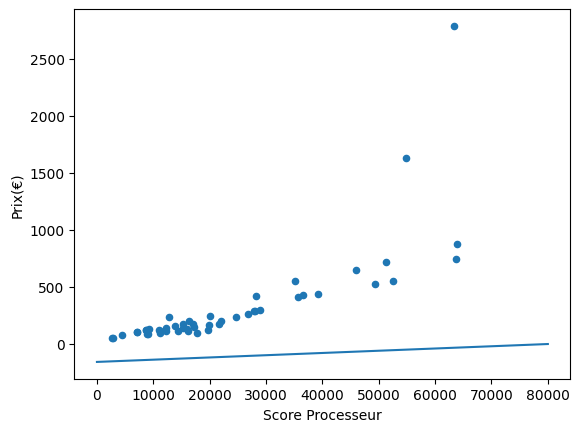

In [ ]:
dataframe_topachat_processeur_2.plot(x="Score Processeur", y="Prix(€)", kind="scatter")
modeleRegression_processeur = LinearRegression()
modeleRegression_processeur.fit(np.array(dataframe_topachat_processeur_2['Score Processeur']).reshape(-1,1), dataframe_topachat_processeur_2['Prix(€)'])

print(dataframe_topachat_processeur_2)
print(modeleRegression_processeur.intercept_)
print(modeleRegression_processeur.coef_)

plt.plot([0,80000],[modeleRegression_processeur.intercept_, modeleRegression_processeur.coef_])

##Ajout des scores au dataframe de la carte graphique

In [ ]:
def composant_appartient_liste(liste, nom_composant):
    for i in liste:
        if (nom_composant.find(i)==-1):
            return False
    return True

In [ ]:
def ajout_carte_graphique_score(dataframe_topachat, dataframe_score):
    liste_score_correspondant = []
    for i in dataframe_topachat.index:
        print("Carte graphique n°"+str(i))
        liste_correspondance_nom = []  
        for j in dataframe_score.index:
            mots_composant = dataframe_score['Nom'][j].split(" ")
            if (composant_appartient_liste(mots_composant, dataframe_topachat['Nom'][i])):
                liste_correspondance_nom.append((dataframe_score['Nom'][j], dataframe_score['Score'][j]))       
        max = len(liste_correspondance_nom[0][0])
        liste_score_correspondant.append(liste_correspondance_nom[0][1])
        for k in range(1,len(liste_correspondance_nom)):
            if (len(liste_correspondance_nom[k][0])> max):
                max = len(liste_correspondance_nom[k][0])
                liste_score_correspondant[i] = liste_correspondance_nom[k][1]
    return liste_score_correspondant
    
liste_score_topachat_cartegraphique = ajout_carte_graphique_score(dataframe_topachat_cartegraphique, dataframe_score_cartegraphique)
#print(liste_score_topachat_cartegraphique)

Carte graphique n°0
Carte graphique n°1
Carte graphique n°2
Carte graphique n°3
Carte graphique n°4
Carte graphique n°5
Carte graphique n°6
Carte graphique n°7
Carte graphique n°8
Carte graphique n°9
Carte graphique n°10
Carte graphique n°11
Carte graphique n°12
Carte graphique n°13
Carte graphique n°14
Carte graphique n°15
Carte graphique n°16
Carte graphique n°17
Carte graphique n°18
Carte graphique n°19
Carte graphique n°20
Carte graphique n°21
Carte graphique n°22
Carte graphique n°23
Carte graphique n°24
Carte graphique n°25
Carte graphique n°26
Carte graphique n°27
Carte graphique n°28
Carte graphique n°29
Carte graphique n°30
Carte graphique n°31
Carte graphique n°32
Carte graphique n°33
Carte graphique n°34
Carte graphique n°35
Carte graphique n°36
Carte graphique n°37
Carte graphique n°38
Carte graphique n°39
Carte graphique n°40
Carte graphique n°41
Carte graphique n°42
Carte graphique n°43
Carte graphique n°44
Carte graphique n°45
Carte graphique n°46
Carte graphique n°47
Ca

##Ajoute de la colonne de score et de performance aux cartes graphiques

In [ ]:
if (type(liste_score_topachat_cartegraphique[0])!=float):
    for i in range(len(liste_score_topachat_cartegraphique)):
        liste_score_topachat_cartegraphique[i] = float(liste_score_topachat_cartegraphique[i])
dataframe_topachat_cartegraphique['Score Carte Graphique'] = liste_score_topachat_cartegraphique

##Rentabilité des Cartes Graphiques (avec Régression Linéaire)
###Les Cartes Graphiques situés sous la droite ont le meilleur rapport qualité-prix

-298.00590950254457
[0.05151021]


/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


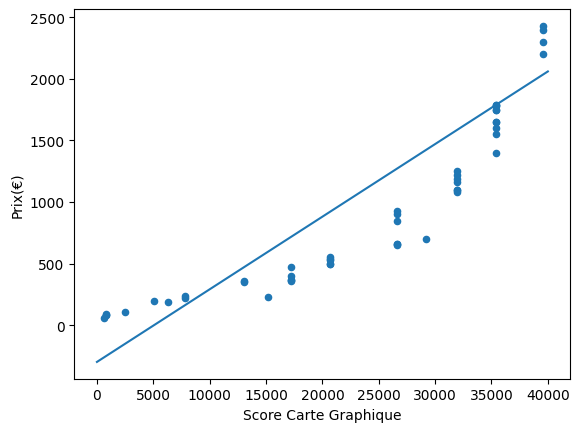

In [ ]:
dataframe_topachat_cartegraphique.plot(x="Score Carte Graphique", y="Prix(€)", kind="scatter")
modeleRegression_cartegraphique = LinearRegression()
modeleRegression_cartegraphique.fit(np.array(dataframe_topachat_cartegraphique['Score Carte Graphique']).reshape(-1,1), dataframe_topachat_cartegraphique['Prix(€)'])

print(modeleRegression_cartegraphique.intercept_)
print(modeleRegression_cartegraphique.coef_)
plt.plot([0,40000],[modeleRegression_cartegraphique.intercept_, modeleRegression_cartegraphique.coef_*40000])


In [ ]:
def ajout_carte_graphique_performance(dataframe_topachat):
    liste_performance = []
    maxi = max(dataframe_topachat['Score Carte Graphique'])
    mini = min(dataframe_topachat['Score Carte Graphique'])
    for i in dataframe_topachat.index:
        liste_performance.append((dataframe_topachat['Score Carte Graphique'][i]-mini)/(maxi-mini))
    dataframe_topachat['Performance']=liste_performance
ajout_carte_graphique_performance(dataframe_topachat_cartegraphique)
print(dataframe_topachat_cartegraphique)

                                                  Nom  Prix(€)  \
0   AMD Radeon RX 6950 XT + The Last of Us Part 1 ...   699.99   
1   AORUS GeForce RTX 4070 MASTER + Diablo IV offe...   849.99   
2   AORUS GeForce RTX 4070 Ti ELITE + Diablo IV of...  1099.99   
3   AORUS GeForce RTX 4070 Ti MASTER + Diablo IV o...  1159.99   
4   AORUS GeForce RTX 4080 MASTER + Diablo IV offe...  1599.99   
5   AORUS GeForce RTX 4080 XTREME WATERFORCE + Dia...  1789.99   
6   AORUS GeForce RTX 4080 XTREME WATERFORCE WB + ...  1649.99   
7   AORUS GeForce RTX 4090 MASTER 24G + Diablo IV ...  2199.99   
8   AORUS GeForce RTX 4090 XTREME WATERFORCE + Dia...  2299.99   
9   AORUS Radeon RX 7900 XTX ELITE 24G + The Last ...  1249.99   
10  ASRock Radeon RX 6600 Challenger D OC + The La...   229.99   
11                     Asus GeForce GT 1030 SL-2G-BRK   109.99   
12                Asus GeForce GT 710 DDR3 EVO (2 Go)    59.99   
13              Asus GeForce GT 730 4H SL 2GD5 (2 Go)    94.99   
14        

#Affichage des meilleures processeurs

In [ ]:
dataframe_topachat_processeur_2 = dataframe_topachat_processeur[dataframe_topachat_processeur['Prix(€)']>1000]
dataframe_topachat_processeur_3 = dataframe_topachat_processeur_2[dataframe_topachat_processeur_2['Score Processeur']>25000]
dataframe_topachat_processeur_3.head(50).sort_values('Score Processeur')

,Nom,Prix(€),Informations Supplementaires,Reference url,Score Processeur,Performance
31,AMD Ryzen Threadripper 3960X (3.8 GHz),1629.99,Processeur Socket TRX4 - 24 coeurs - Cache 140...,https://www.topachat.com/pages/detail2_cat_est...,54814.0,0.664180
32,AMD Ryzen Threadripper 3970X (3.7 GHz),2789.99,Processeur Socket TRX4 - 32 Coeurs - Cache 144...,https://www.topachat.com/pages/detail2_cat_est...,63436.0,0.774122
33,AMD Ryzen Threadripper 3990X (2.9 GHz),5159.99,Processeur Socket TRX4 - 64 coeurs - Cache 288...,https://www.topachat.com/pages/detail2_cat_est...,81150.0,1.000000


#Affichage des meilleures cartes graphiques

In [ ]:
dataframe_topachat_cartegraphique2 = dataframe_topachat_cartegraphique[dataframe_topachat_cartegraphique['Prix(€)']>1000]
dataframe_topachat_cartegraphique3 = dataframe_topachat_cartegraphique2[dataframe_topachat_cartegraphique2['Score Carte Graphique']>25000]
dataframe_topachat_cartegraphique3.head(50).sort_values('Score Carte Graphique')

,Nom,Prix(€),Informations Supplementaires,Reference url,Score Carte Graphique,Performance
9,AORUS Radeon RX 7900 XTX ELITE 24G + The Last ...,1249.99,Carte graphique overclockée - Refroidissement ...,https://www.topachat.com/pages/detail2_cat_est...,31970.0,0.804276
2,AORUS GeForce RTX 4070 Ti ELITE + Diablo IV of...,1099.99,Carte graphique - Refroidissement semi-passif ...,https://www.topachat.com/pages/detail2_cat_est...,31975.0,0.804404
38,ASUS GeForce RTX 4070 Ti TUF O12G GAMING + Dia...,1099.99,Carte graphique overclockée - Refroidissement ...,https://www.topachat.com/pages/detail2_cat_est...,31975.0,0.804404
36,ASUS GeForce RTX 4070 Ti ROG STRIX O12G GAMING...,1219.99,Carte graphique overclockée - Refroidissement ...,https://www.topachat.com/pages/detail2_cat_est...,31975.0,0.804404
35,ASUS GeForce RTX 4070 Ti ROG STRIX 12G GAMING ...,1189.99,Carte graphique - Refroidissement semi-passif ...,https://www.topachat.com/pages/detail2_cat_est...,31975.0,0.804404
37,ASUS GeForce RTX 4070 Ti TUF 12G GAMING + Diab...,1079.99,Carte graphique - Refroidissement semi-passif ...,https://www.topachat.com/pages/detail2_cat_est...,31975.0,0.804404
3,AORUS GeForce RTX 4070 Ti MASTER + Diablo IV o...,1159.99,Carte graphique - Refroidissement semi-passif ...,https://www.topachat.com/pages/detail2_cat_est...,31975.0,0.804404
6,AORUS GeForce RTX 4080 XTREME WATERFORCE WB + ...,1649.99,Carte graphique - Waterblock intégré - Avec ba...,https://www.topachat.com/pages/detail2_cat_est...,35374.0,0.891641
5,AORUS GeForce RTX 4080 XTREME WATERFORCE + Dia...,1789.99,Carte graphique - Refroidissement hybride et s...,https://www.topachat.com/pages/detail2_cat_est...,35374.0,0.891641
4,AORUS GeForce RTX 4080 MASTER + Diablo IV offe...,1599.99,Carte graphique - Refroidissement semi-passif ...,https://www.topachat.com/pages/detail2_cat_est...,35374.0,0.891641


#Correspondance Socket/Chipset et Chipset/Frequence

In [ ]:
dico_correspondance_socket_chipset = {"1700":["B360","B365","H110","H310","H370","Z390","B660","HB660","B760","H610","H670","Z690","Z790"], 
                                      "1200":["B460","H410","H470","Z490","H510","Z590","B560"], 
                                      "2066":["X299"], 
                                      "AM4":["A320","A520","B450","B550","X470","X570"],
                                      "TRX4":["TRX40"]}

dico_correspondance_chipset_frequenceRAM = {"B360":[2133, 2666], 
                                            "B365":[2133, 2666], 
                                            "H110":[2133], 
                                            "H310":[2133, 2666],
                                            "H370":[2133, 2666], 
                                            "Z390":[2133, 4000], 
                                            "B460":[2133, 2933], 
                                            "H410":[2133, 2933], 
                                            "H470":[2133, 2933], 
                                            "Z490":[2133, 4600], 
                                            "X299": [2133, 4200], 
                                            "A320":[2133, 2666], 
                                            "A520": [2133, 5000], 
                                            "B450":[2133, 3466], 
                                            "B550":[2133, 4400],
                                            "X470":[2133, 4133], 
                                            "X570":[1866, 4400], 
                                            "TRX40":[2133, 4666]
                                           }

# Preprocessing des cartes mère et de la RAM

## Fonction qui ajoute une colonne 'chipset' aux cartes mères

In [ ]:
def ajout_chipset_carte_mere(dataframe_carte_mere, socket):
    Chipset = []
    liste_chipset = dico_correspondance_socket_chipset[socket]
    for i in dataframe_carte_mere.index:
        #print(dataframe_carte_mere['Informations Supplementaires'][i])
        liste_infos = dataframe_carte_mere['Informations Supplementaires'][i].split(" ")
        for indice_mot in range (len(liste_infos)):
            if(liste_infos[indice_mot] == "Chipset"):
                if (liste_infos[indice_mot + 2] not in liste_chipset) :
                    #print(liste_infos[indice_mot + 2])
                    Chipset.append("NaN")
                else:
                    Chipset.append(liste_infos[indice_mot + 2])
    dataframe_carte_mere['Chipset'] = Chipset

## Fonction qui ajoute les caractéristiques des RAM aux cartes mères

In [ ]:
def ajout_caracteristique_ram(dataframe_carte_mere):
    liste_nombre_slots = []
    liste_giga_max = []
    for i in dataframe_carte_mere.index:
        page_topachat = requests.get(dataframe_carte_mere["Reference url"][i])
        soup_topachat = BeautifulSoup(page_topachat.text, "html.parser")
        memoire = soup_topachat.findAll('div', attrs = {"class":"carac"})

        index_memoire = -1
        for j in range (len(memoire)):
            if (memoire[j].find('div', attrs = {'class':'caracName'}).text == "Mémoire"):
                index_memoire = j
        info_memoire = memoire[index_memoire].findAll('li')
        if (len(info_memoire)==0):  
            nombre_slots = memoire[index_memoire].find('span').text[0]
            info_memoire = memoire[index_memoire].findAll('span')
        else :
            nombre_slots = info_memoire[0].text[0]
        liste_nombre_slots.append(nombre_slots)
        boolean = True
        compteur = -1
        while(boolean):
            compteur += 1
            if(compteur ==len(info_memoire)):
                liste_giga_max.append("NaN")
                boolean = False
                break
            separation = info_memoire[compteur].text.split(" ")
            for k in range(len(separation)):
                if(separation[k].find("Go")!=-1):
                    if (separation[k-1].find("max.") != -1):
                        liste_giga_max.append(separation[k-1][4:])
                    elif (separation[k-1].find("*") != -1):
                        liste_giga_max.append(separation[k-1][:-1])
                    else:
                        liste_giga_max.append(separation[k-1])
                    boolean = False
                    break
                elif (separation[k].find("GB")!=-1):
                    if (separation[k].find("max.") != -1):
                        liste_giga_max.append(separation[k][4:separation[k].find("GB")])
                    elif (separation[k].find("*") != -1):
                        liste_giga_max.append(separation[k][:-1])
                    else:
                        liste_giga_max.append(separation[k][:separation[k].find("GB")])
                    boolean = False
                    break
            
    dataframe_carte_mere['Slots'] = liste_nombre_slots
    dataframe_carte_mere['Go max'] = liste_giga_max

In [ ]:
#ajout chipset 1700
ajout_chipset_carte_mere(dataframe_topachat_1700, "1700")
ajout_caracteristique_ram(dataframe_topachat_1700)
#print(dataframe_topachat_1700)
print("Le nombre de NaN dans notre dataframe 1700 pour les chipsets est de : "+str((dataframe_topachat_1700['Chipset'] == "NaN").sum())+"\n")

Le nombre de NaN dans notre dataframe 1700 pour les chipsets est de : 0



In [ ]:
#ajout chipset 1200
ajout_chipset_carte_mere(dataframe_topachat_1200, "1200")
dataframe_topachat_1200.loc[dataframe_topachat_1200['Nom']=="ASRock B460M Steel Legend", "Chipset"] = "B460"
ajout_caracteristique_ram(dataframe_topachat_1200)
#print(dataframe_topachat_1200)
print("Le nombre de NaN dans notre dataframe 1200 pour les chipsets est de : "+str((dataframe_topachat_1200['Chipset'] == "NaN").sum())+"\n")

Le nombre de NaN dans notre dataframe 1200 pour les chipsets est de : 0



In [ ]:
#ajout chipset 2066
ajout_chipset_carte_mere(dataframe_topachat_2066, "2066")
ajout_caracteristique_ram(dataframe_topachat_2066)
#print(dataframe_topachat_2066)
print("Le nombre de NaN dans notre dataframe 2066 pour les chipsets est de : "+str((dataframe_topachat_2066['Chipset'] == "NaN").sum())+"\n")

Le nombre de NaN dans notre dataframe 2066 pour les chipsets est de : 0



In [ ]:
#ajout chipset AM4
ajout_chipset_carte_mere(dataframe_topachat_AM4, "AM4")
ajout_caracteristique_ram(dataframe_topachat_AM4)
#print(dataframe_topachat_AM4)
print("Le nombre de NaN dans notre dataframe AM4 pour les chipsets est de : "+str((dataframe_topachat_AM4['Chipset'] == "NaN").sum())+"\n")


Le nombre de NaN dans notre dataframe AM4 pour les chipsets est de : 0



## Fonction qui supprime les RAM factices de notre dataframe

In [ ]:
def supprimer_factices(dataframe_RAM):
    for i in dataframe_RAM.index :
        if(dataframe_RAM['Informations Supplementaires'][i].find("factices")!=-1):
            dataframe_RAM.drop([i], inplace=True)
        elif(dataframe_RAM['Nom'][i].find("Apple")!=-1):
            dataframe_RAM.drop([i], inplace=True)

##Fonction qui ajoute les informations des RAMs au dataframe RAM

In [ ]:
def ajout_info_ram(dataframe_RAM):
    supprimer_factices(dataframe_RAM)
    CAS = []
    Stockage = []
    Nb_barrettes = []
    Frequence = []
    for i in dataframe_RAM.index :
        liste_nb_barrettes = dataframe_RAM['Nom'][i].split("(")
        if len(liste_nb_barrettes) == 1 :
            Nb_barrettes.append("1")
        elif len(liste_nb_barrettes) == 2:
            Nb_barrettes.append(liste_nb_barrettes[1][0])
        indice_tiret = dataframe_RAM['Nom'][i].find("-")
        indice_Go = dataframe_RAM['Nom'][i].find("Go")
        if (dataframe_RAM['Nom'][i][indice_tiret+2:indice_Go-1]==''):
            liste_Go = dataframe_RAM['Nom'][i].split(" ")
            indice = -1
            for j in range(len(liste_Go)):
                if(liste_Go[j]=="Go"):
                    indice = j-1
            Stockage.append(int(liste_Go[indice]))
        else:
            Stockage.append(int(dataframe_RAM['Nom'][i][indice_tiret+2:indice_Go-1]))
        liste_infos = dataframe_RAM['Nom'][i].split(" ")
        for indice_mot in range (len(liste_infos)) :
            #print (liste_infos[indice_mot])
            if (liste_infos[indice_mot] == "MHz"):
                Frequence.append(int(liste_infos[indice_mot -1]))
            elif(liste_infos[indice_mot] == "Mhz"):
                Frequence.append(int(liste_infos[indice_mot -1]))
            if (liste_infos[indice_mot] == "CAS"):
                CAS.append(int(liste_infos[indice_mot+1]))
            
    dataframe_RAM['Stockage'] = Stockage
    dataframe_RAM['Nb_barrettes'] = Nb_barrettes
    #print(len(Frequence))
    #print(len(dataframe_RAM))
    dataframe_RAM['Frequence'] = Frequence
    dataframe_RAM['CAS'] = CAS
  

In [ ]:
ajout_info_ram(dataframe_topachat_DDR4)

In [ ]:
#print(dataframe_topachat_DDR4.loc[418])
def performance_RAM(dataframe_RAM):
    liste_performance = []
    maxFrequence = dataframe_RAM['Frequence'].max()
    minFrequence = dataframe_RAM['Frequence'].min()
    maxStockage = max(dataframe_RAM['Stockage'])
    minStockage = min(dataframe_RAM['Stockage'])
    maxCAS = 20
    minCAS = 12
    for i in dataframe_RAM.index:
        #print(int(dataframe_RAM['Stockage'][i])-minStockage)
        liste_performance.append((((0.3*(int(dataframe_RAM['Stockage'][i])-minStockage)/(maxStockage-minStockage))+(0.5*(int(dataframe_RAM['Frequence'][i])-minFrequence)/(maxFrequence-minFrequence))+0.2*(maxCAS - int(dataframe_RAM['CAS'][i]))/(maxCAS-minCAS))))
    dataframe_RAM['Performance'] = liste_performance
    


In [ ]:
performance_RAM(dataframe_topachat_DDR4)
#print(dataframe_topachat_DDR4['Nb_barrettes'])

# Application Finale

## Fonction qui ajoute les sockets aux processeurs


In [ ]:
def ajout_socket_processeur(dataframe_processeur):
    Socket = []
    liste_sockets = ["AM4", "1151", "1200", "TRX4", "2066"]
    for i in dataframe_processeur.index :
        liste_infos = dataframe_processeur['Informations Supplementaires'][i].split(" ")
        for indice_mot in range (len(liste_infos)) :
            if (liste_infos[indice_mot] == "Socket"):
                if (liste_infos[indice_mot + 1] not in liste_sockets) :
                    Socket.append("NaN")
                else:
                    Socket.append(liste_infos[indice_mot + 1])

    dataframe_processeur['Socket'] = Socket

In [ ]:
ajout_socket_processeur(dataframe_topachat_processeur)

## Fonction qui détermine la meilleure configuration pour un certain prix (carte mère, processeur, ram, carte graphique)

In [ ]:
def combi_articles(solde, df_alim, df_boitier, df_ssd, df_watercooling):
    # Création de la liste de tuples contenant tous les articles des dataframes passés en paramètre
    articles_alim = [(row["Nom Alimentation"], row["Prix(€)"]) for index, row in df_alim.iterrows()]
    articles_boitier = [(row["Nom Boitier"], row["Prix(€)"]) for index, row in df_boitier.iterrows()]
    articles_ssd = [(row["Nom Stockage"], row["Prix(€)"]) for index, row in df_ssd.iterrows()]
    articles_watercooling = [(row["Nom Refroidisseur"], row["Prix(€)"]) for index, row in df_watercooling.iterrows()]

    # Création de toutes les combinaisons possibles d'articles avec itertools.product
    combinaisons = list(itertools.product(articles_alim, articles_boitier, articles_ssd, articles_watercooling))

    # Création du dataframe résultat
    df_combi = pd.DataFrame(columns=["nom_alim", "prix_alim", "nom_boitier", "prix_boitier", "nom_ssd", "prix_ssd", "nom_watercooling", "prix_watercooling", "prix_total"])

    # Ajout des combinaisons valides dans le dataframe résultat
    for combi in combinaisons:
        prix_total = sum([a[1] for a in combi])
        if prix_total <= solde:
            df_combi = df_combi.append({
                "nom_alim": combi[0][0],
                "prix_alim": combi[0][1],
                "nom_boitier": combi[1][0],
                "prix_boitier": combi[1][1],
                "nom_ssd": combi[2][0],
                "prix_ssd": combi[2][1],
                "nom_watercooling": combi[3][0],
                "prix_watercooling": combi[3][1],
                "prix_total": prix_total
            }, ignore_index=True)

    return df_combi


In [ ]:
def combinaison_configuration(prix, fonctionnalite, stockage="defaut", gigaRAM=0, processeur="defaut", carteGraphique="defaut", carteMere="defaut"):
    if (fonctionnalite=="Ordinateur Gaming"):
        poids_processeur = 0.2
        poids_cartegraphique = 0.25
        poids_ram =0.05

        poids_boitier = 0.1
        poids_alim = 0.1
        poids_SDD = 0.15
        poids_watercooling = 0.1

        incertitude_poids = 0.05
        incertitude_poids_ram = 0.01
        
        minimum_prix_ram = (poids_ram-incertitude_poids_ram)*prix
        maximum_prix_ram = (poids_ram+incertitude_poids_ram)*prix
        
        minimum_prix_processeur = (poids_processeur-incertitude_poids)*prix
        maximum_prix_processeur = (poids_processeur+incertitude_poids)*prix
       
        minimum_prix_cartegraphique = (poids_cartegraphique-incertitude_poids)*prix
        maximum_prix_cartegraphique = (poids_cartegraphique+incertitude_poids)*prix

        minimum_prix_boitier = (poids_boitier-incertitude_poids)*prix
        maximum_prix_boitier = (poids_boitier+incertitude_poids)*prix
        
        minimum_prix_alimentation = (poids_alim-incertitude_poids)*prix
        maximum_prix_alimentation = (poids_alim+incertitude_poids)*prix

        minimum_prix_sdd = (poids_SDD-incertitude_poids)*prix
        maximum_prix_sdd = (poids_SDD+incertitude_poids)*prix

        minimum_prix_watercooling = (poids_watercooling-incertitude_poids)*prix
        maximum_prix_watercooling = (poids_watercooling+incertitude_poids)*prix

        dataframe_tranche_prix_processeur = dataframe_topachat_processeur[(dataframe_topachat_processeur['Prix(€)']<maximum_prix_processeur) & (dataframe_topachat_processeur['Prix(€)']>minimum_prix_processeur)]
        dataframe_tranche_prix_processeur = dataframe_tranche_prix_processeur.rename(columns={"Nom":"Nom Processeur", "Prix(€)":"Prix(€) Processeur", "Informations Supplementaires":"Informations Supplementaires Processeur", "Reference url":"Reference url Processeur"})
        
        dataframe_tranche_prix_cartegraphique = dataframe_topachat_cartegraphique[(dataframe_topachat_cartegraphique['Prix(€)']<maximum_prix_cartegraphique) & (dataframe_topachat_cartegraphique['Prix(€)']>minimum_prix_cartegraphique)]
        dataframe_tranche_prix_cartegraphique = dataframe_tranche_prix_cartegraphique.rename(columns={"Nom":"Nom Carte Graphique", "Prix(€)":"Prix(€) Carte Graphique", "Informations Supplementaires":"Informations Supplementaires Carte Graphique", "Reference url":"Reference url Carte Graphique"})
        
        dataframe_tranche_prix_ram = dataframe_topachat_DDR4[(dataframe_topachat_DDR4['Prix(€)']<maximum_prix_ram) & (dataframe_topachat_DDR4['Prix(€)']>minimum_prix_ram)]
        dataframe_tranche_prix_ram = dataframe_tranche_prix_ram.rename(columns={"Nom":"Nom RAM", "Prix(€)":"Prix(€) RAM", "Informations Supplementaires":"Informations Supplementaires RAM", "Reference url":"Reference url RAM"})
        
        dataframe_tranche_prix_alimentation = dataframe_topachat_alimentation[(dataframe_topachat_alimentation['Prix(€)'] < maximum_prix_alimentation) & (dataframe_topachat_alimentation['Prix(€)'] > minimum_prix_alimentation)]
        dataframe_tranche_prix_alimentation = dataframe_tranche_prix_alimentation.rename(columns={"Nom":"Nom Alimentation", "Informations Supplementaires":"Informations Supplementaires Alimentation", "Reference url":"Reference url Alimentation"})

        dataframe_tranche_prix_boitier = dataframe_topachat_boitier[(dataframe_topachat_boitier['Prix(€)'] < maximum_prix_boitier) & (dataframe_topachat_boitier['Prix(€)'] > minimum_prix_boitier)]
        dataframe_tranche_prix_boitier = dataframe_tranche_prix_boitier.rename(columns={"Nom":"Nom Boitier", "Informations Supplementaires":"Informations Supplementaires Boitier", "Reference url":"Reference url Boitier"})

        dataframe_tranche_prix_sdd = dataframe_topachat_ssd[(dataframe_topachat_ssd['Prix(€)'] < maximum_prix_sdd) & (dataframe_topachat_ssd['Prix(€)'] > minimum_prix_sdd)]
        dataframe_tranche_prix_sdd = dataframe_tranche_prix_sdd.rename(columns={"Nom":"Nom Stockage",  "Informations Supplementaires":"Informations Supplementaires SSD", "Reference url":"Reference url SSD"})

        dataframe_tranche_prix_watercooling = dataframe_topachat_refroidissement[(dataframe_topachat_refroidissement['Prix(€)'] < maximum_prix_watercooling) & (dataframe_topachat_refroidissement['Prix(€)'] > minimum_prix_watercooling)]
        dataframe_tranche_prix_watercooling = dataframe_tranche_prix_watercooling.rename(columns={"Nom":"Nom Refroidisseur", "Informations Supplementaires":"Informations Supplementaires Watercooling", "Reference url":"Reference url Watercooling"})


        dataframe_cartesien_AM4_ram = ajout_ram_carte_mere(dataframe_topachat_AM4,dataframe_tranche_prix_ram)
        dataframe_cartesien_1151_ram = ajout_ram_carte_mere(dataframe_topachat_1700,dataframe_tranche_prix_ram)
        dataframe_cartesien_1200_ram = ajout_ram_carte_mere(dataframe_topachat_1200,dataframe_tranche_prix_ram) 
        dataframe_cartesien_2066_ram = ajout_ram_carte_mere(dataframe_topachat_2066,dataframe_tranche_prix_ram)
        dataframe_cartesien_CM_RAM_processeur = ajout_processeur_CM_RAM(dataframe_cartesien_AM4_ram, dataframe_cartesien_1151_ram, dataframe_cartesien_1200_ram, dataframe_cartesien_2066_ram, dataframe_tranche_prix_processeur)

        meilleur_ordinateur = meilleure_configuration(prix, dataframe_tranche_prix_processeur, dataframe_tranche_prix_cartegraphique, dataframe_cartesien_AM4_ram, dataframe_cartesien_1151_ram, dataframe_cartesien_1200_ram, dataframe_cartesien_2066_ram)

        if (meilleur_ordinateur[3]=="AM4"):
            liste_meilleur_ordinateur = [dataframe_tranche_prix_processeur.loc[meilleur_ordinateur[0]], 
                                         dataframe_tranche_prix_cartegraphique.loc[meilleur_ordinateur[1]], 
                                         dataframe_cartesien_AM4_ram.loc[meilleur_ordinateur[2]]]
        if (meilleur_ordinateur[3]=="1700"):
            liste_meilleur_ordinateur = [dataframe_tranche_prix_processeur.loc[meilleur_ordinateur[0]], 
                                         dataframe_tranche_prix_cartegraphique.loc[meilleur_ordinateur[1]], 
                                         dataframe_cartesien_1151_ram.loc[meilleur_ordinateur[2]]]
        if (meilleur_ordinateur[3]=="1200"):
            liste_meilleur_ordinateur = [dataframe_tranche_prix_processeur.loc[meilleur_ordinateur[0]], 
                                         dataframe_tranche_prix_cartegraphique.loc[meilleur_ordinateur[1]], 
                                         dataframe_cartesien_1200_ram.loc[meilleur_ordinateur[2]]]
        if (meilleur_ordinateur[3]=="2066"):
            liste_meilleur_ordinateur = [dataframe_tranche_prix_processeur.loc[meilleur_ordinateur[0]], 
                                         dataframe_tranche_prix_cartegraphique.loc[meilleur_ordinateur[1]], 
                                         dataframe_cartesien_2066_ram.loc[meilleur_ordinateur[2]]]


        prix_cpu = liste_meilleur_ordinateur[0]["Prix(€) Processeur"]
        prix_gpu = liste_meilleur_ordinateur[1]["Prix(€) Carte Graphique"]
        prix_carte_mere = liste_meilleur_ordinateur[2]["Prix(€) Carte mère"]
        prix_ram = liste_meilleur_ordinateur[2]["Prix(€) RAM"]
        prix_total_prim = prix_cpu + prix_gpu + prix_carte_mere + prix_ram
        solde_restant = prix - prix_total_prim

        #combi_articles(solde_restant,dataframe_tranche_prix_alimentation,dataframe_tranche_prix_boitier,dataframe_tranche_prix_sdd,dataframe_tranche_prix_watercooling).to_csv('combinaisons_ordinateur_gaming.csv', index = True)
        
        data = {'Nom Processeur': [liste_meilleur_ordinateur[0]["Nom Processeur"]],
                'Prix(€) Processeur': [liste_meilleur_ordinateur[0]["Prix(€) Processeur"]],
                'Informations Supplementaires Processeur': [liste_meilleur_ordinateur[0]["Informations Supplementaires Processeur"]],
                'Reference url Processeur':[liste_meilleur_ordinateur[0]["Reference url Processeur"]],
                'Socket':[liste_meilleur_ordinateur[0]["Socket"]],
                'Nom Carte Graphique':[liste_meilleur_ordinateur[1]["Nom Carte Graphique"]],
                'Prix(€) Carte Graphique':[liste_meilleur_ordinateur[1]["Prix(€) Carte Graphique"]],
                'Informations Supplementaires Carte Graphique':[liste_meilleur_ordinateur[1]["Informations Supplementaires Carte Graphique"]],
                'Reference url Carte Graphique':[liste_meilleur_ordinateur[1]["Reference url Carte Graphique"]],
                'Nom Carte mère':[liste_meilleur_ordinateur[2]["Nom Carte mère"]],
                'Prix(€) Carte mère':[liste_meilleur_ordinateur[2]["Prix(€) Carte mère"]],
                'Informations Supplementaires Carte mère':[liste_meilleur_ordinateur[2]["Informations Supplementaires Carte mère"]],
                'Reference url Carte mère':[liste_meilleur_ordinateur[2]["Reference url Carte mère"]],
                'Slots Carte mère':[liste_meilleur_ordinateur[2]["Slots Carte mère"]],
                'Go max Carte mère':[liste_meilleur_ordinateur[2]["Go max Carte mère"]],
                'Nom RAM':[liste_meilleur_ordinateur[2]["Nom RAM"]],
                'Prix(€) RAM':[liste_meilleur_ordinateur[2]["Prix(€) RAM"]],
                'Informations Supplementaires RAM':[liste_meilleur_ordinateur[2]["Informations Supplementaires RAM"]],
                'Reference url RAM':[liste_meilleur_ordinateur[2]["Reference url RAM"]],
                'Stockage RAM':[liste_meilleur_ordinateur[2]["Stockage RAM"]],
                'Nb_barrettes RAM':[liste_meilleur_ordinateur[2]["Nb_barrettes RAM"]],
        }

        df = pd.DataFrame(data)
						 			

        return df

    elif(fonctionnalite=="Ordinateur Général"):
        poids_processeur = 0.2
        poids_cartegraphique = 0.1
        poids_ram = 0.05

        poids_boitier = 0.1
        poids_alim = 0.1
        poids_SDD = 0.15
        poids_watercooling = 0.1

        incertitude_poids = 0.05
        incertitude_poids_ram = 0.01

        minimum_prix_ram = (poids_ram-incertitude_poids_ram)*prix
        maximum_prix_ram = (poids_ram+incertitude_poids_ram)*prix
        
        minimum_prix_processeur = (poids_processeur-incertitude_poids)*prix
        maximum_prix_processeur = (poids_processeur+incertitude_poids)*prix
       
        minimum_prix_cartegraphique = (poids_cartegraphique-incertitude_poids)*prix
        maximum_prix_cartegraphique = (poids_cartegraphique+incertitude_poids)*prix

        minimum_prix_boitier = (poids_boitier-incertitude_poids)*prix
        maximum_prix_boitier = (poids_boitier+incertitude_poids)*prix
        
        minimum_prix_alimentation = (poids_alim-incertitude_poids)*prix
        maximum_prix_alimentation = (poids_alim+incertitude_poids)*prix

        minimum_prix_sdd = (poids_SDD-incertitude_poids)*prix
        maximum_prix_sdd = (poids_SDD+incertitude_poids)*prix

        minimum_prix_watercooling = (poids_watercooling-incertitude_poids)*prix
        maximum_prix_watercooling = (poids_watercooling+incertitude_poids)*prix

        dataframe_tranche_prix_processeur = dataframe_topachat_processeur[(dataframe_topachat_processeur['Prix(€)']<maximum_prix_processeur) & (dataframe_topachat_processeur['Prix(€)']>minimum_prix_processeur)]
        dataframe_tranche_prix_processeur = dataframe_tranche_prix_processeur.rename(columns={"Nom":"Nom Processeur", "Prix(€)":"Prix(€) Processeur", "Informations Supplementaires":"Informations Supplementaires Processeur", "Reference url":"Reference url Processeur"})
        
        dataframe_tranche_prix_cartegraphique = dataframe_topachat_cartegraphique[(dataframe_topachat_cartegraphique['Prix(€)']<maximum_prix_cartegraphique) & (dataframe_topachat_cartegraphique['Prix(€)']>minimum_prix_cartegraphique)]
        dataframe_tranche_prix_cartegraphique = dataframe_tranche_prix_cartegraphique.rename(columns={"Nom":"Nom Carte Graphique", "Prix(€)":"Prix(€) Carte Graphique", "Informations Supplementaires":"Informations Supplementaires Carte Graphique", "Reference url":"Reference url Carte Graphique"})
        
        dataframe_tranche_prix_ram = dataframe_topachat_DDR4[(dataframe_topachat_DDR4['Prix(€)']<maximum_prix_ram) & (dataframe_topachat_DDR4['Prix(€)']>minimum_prix_ram)]
        dataframe_tranche_prix_ram = dataframe_tranche_prix_ram.rename(columns={"Nom":"Nom RAM", "Prix(€)":"Prix(€) RAM", "Informations Supplementaires":"Informations Supplementaires RAM", "Reference url":"Reference url RAM"})
        
        dataframe_tranche_prix_alimentation = dataframe_topachat_alimentation[(dataframe_topachat_alimentation['Prix(€)'] < maximum_prix_alimentation) & (dataframe_topachat_alimentation['Prix(€)'] > minimum_prix_alimentation)]
        dataframe_tranche_prix_alimentation = dataframe_tranche_prix_alimentation.rename(columns={"Nom":"Nom Alimentation", "Informations Supplementaires":"Informations Supplementaires Alimentation", "Reference url":"Reference url Alimentation"})

        dataframe_tranche_prix_boitier = dataframe_topachat_boitier[(dataframe_topachat_boitier['Prix(€)'] < maximum_prix_boitier) & (dataframe_topachat_boitier['Prix(€)'] > minimum_prix_boitier)]
        dataframe_tranche_prix_boitier = dataframe_tranche_prix_boitier.rename(columns={"Nom":"Nom Boitier", "Informations Supplementaires":"Informations Supplementaires Boitier", "Reference url":"Reference url Boitier"})

        dataframe_tranche_prix_sdd = dataframe_topachat_ssd[(dataframe_topachat_ssd['Prix(€)'] < maximum_prix_sdd) & (dataframe_topachat_ssd['Prix(€)'] > minimum_prix_sdd)]
        dataframe_tranche_prix_sdd = dataframe_tranche_prix_sdd.rename(columns={"Nom":"Nom Stockage",  "Informations Supplementaires":"Informations Supplementaires SSD", "Reference url":"Reference url SSD"})

        dataframe_tranche_prix_watercooling = dataframe_topachat_refroidissement[(dataframe_topachat_refroidissement['Prix(€)'] < maximum_prix_watercooling) & (dataframe_topachat_refroidissement['Prix(€)'] > minimum_prix_watercooling)]
        dataframe_tranche_prix_watercooling = dataframe_tranche_prix_watercooling.rename(columns={"Nom":"Nom Refroidisseur", "Informations Supplementaires":"Informations Supplementaires Watercooling", "Reference url":"Reference url Watercooling"})

        dataframe_cartesien_AM4_ram = ajout_ram_carte_mere(dataframe_topachat_AM4,dataframe_tranche_prix_ram)
        dataframe_cartesien_1151_ram = ajout_ram_carte_mere(dataframe_topachat_1700,dataframe_tranche_prix_ram)
        dataframe_cartesien_1200_ram = ajout_ram_carte_mere(dataframe_topachat_1200,dataframe_tranche_prix_ram) 
        dataframe_cartesien_2066_ram = ajout_ram_carte_mere(dataframe_topachat_2066,dataframe_tranche_prix_ram)
        dataframe_cartesien_CM_RAM_processeur = ajout_processeur_CM_RAM(dataframe_cartesien_AM4_ram, dataframe_cartesien_1151_ram, dataframe_cartesien_1200_ram, dataframe_cartesien_2066_ram, dataframe_tranche_prix_processeur)

        meilleur_ordinateur = meilleure_configuration(prix, dataframe_tranche_prix_processeur, dataframe_tranche_prix_cartegraphique, dataframe_cartesien_AM4_ram, dataframe_cartesien_1151_ram, dataframe_cartesien_1200_ram, dataframe_cartesien_2066_ram)

        if (meilleur_ordinateur[3]=="AM4"):
            liste_meilleur_ordinateur = [dataframe_tranche_prix_processeur.loc[meilleur_ordinateur[0]], 
                                         dataframe_tranche_prix_cartegraphique.loc[meilleur_ordinateur[1]], 
                                         dataframe_cartesien_AM4_ram.loc[meilleur_ordinateur[2]]]
        if (meilleur_ordinateur[3]=="1700"):
            liste_meilleur_ordinateur = [dataframe_tranche_prix_processeur.loc[meilleur_ordinateur[0]], 
                                         dataframe_tranche_prix_cartegraphique.loc[meilleur_ordinateur[1]], 
                                         dataframe_cartesien_1151_ram.loc[meilleur_ordinateur[2]]]
        if (meilleur_ordinateur[3]=="1200"):
            liste_meilleur_ordinateur = [dataframe_tranche_prix_processeur.loc[meilleur_ordinateur[0]], 
                                         dataframe_tranche_prix_cartegraphique.loc[meilleur_ordinateur[1]], 
                                         dataframe_cartesien_1200_ram.loc[meilleur_ordinateur[2]]]
        if (meilleur_ordinateur[3]=="2066"):
            liste_meilleur_ordinateur = [dataframe_tranche_prix_processeur.loc[meilleur_ordinateur[0]], 
                                         dataframe_tranche_prix_cartegraphique.loc[meilleur_ordinateur[1]], 
                                         dataframe_cartesien_2066_ram.loc[meilleur_ordinateur[2]]]

        prix_cpu = liste_meilleur_ordinateur[0]["Prix(€) Processeur"]
        prix_gpu = liste_meilleur_ordinateur[1]["Prix(€) Carte Graphique"]
        prix_carte_mere = liste_meilleur_ordinateur[2]["Prix(€) Carte mère"]
        prix_ram = liste_meilleur_ordinateur[2]["Prix(€) RAM"]
        prix_total_prim = prix_cpu + prix_gpu + prix_carte_mere + prix_ram
        solde_restant = prix - prix_total_prim

        #combi_articles(solde_restant,dataframe_tranche_prix_alimentation,dataframe_tranche_prix_boitier,dataframe_tranche_prix_sdd,dataframe_tranche_prix_watercooling).to_csv('combinaisons_ordinateur_general.csv', index = True)

        data = {'Nom Processeur': [liste_meilleur_ordinateur[0]["Nom Processeur"]],
                'Prix(€) Processeur': [liste_meilleur_ordinateur[0]["Prix(€) Processeur"]],
                'Informations Supplementaires Processeur': [liste_meilleur_ordinateur[0]["Informations Supplementaires Processeur"]],
                'Reference url Processeur':[liste_meilleur_ordinateur[0]["Reference url Processeur"]],
                'Socket':[liste_meilleur_ordinateur[0]["Socket"]],
                'Nom Carte Graphique':[liste_meilleur_ordinateur[1]["Nom Carte Graphique"]],
                'Prix(€) Carte Graphique':[liste_meilleur_ordinateur[1]["Prix(€) Carte Graphique"]],
                'Informations Supplementaires Carte Graphique':[liste_meilleur_ordinateur[1]["Informations Supplementaires Carte Graphique"]],
                'Reference url Carte Graphique':[liste_meilleur_ordinateur[1]["Reference url Carte Graphique"]],
                'Nom Carte mère':[liste_meilleur_ordinateur[2]["Nom Carte mère"]],
                'Prix(€) Carte mère':[liste_meilleur_ordinateur[2]["Prix(€) Carte mère"]],
                'Informations Supplementaires Carte mère':[liste_meilleur_ordinateur[2]["Informations Supplementaires Carte mère"]],
                'Reference url Carte mère':[liste_meilleur_ordinateur[2]["Reference url Carte mère"]],
                'Slots Carte mère':[liste_meilleur_ordinateur[2]["Slots Carte mère"]],
                'Go max Carte mère':[liste_meilleur_ordinateur[2]["Go max Carte mère"]],
                'Nom RAM':[liste_meilleur_ordinateur[2]["Nom RAM"]],
                'Prix(€) RAM':[liste_meilleur_ordinateur[2]["Prix(€) RAM"]],
                'Informations Supplementaires RAM':[liste_meilleur_ordinateur[2]["Informations Supplementaires RAM"]],
                'Reference url RAM':[liste_meilleur_ordinateur[2]["Reference url RAM"]],
                'Stockage RAM':[liste_meilleur_ordinateur[2]["Stockage RAM"]],
                'Nb_barrettes RAM':[liste_meilleur_ordinateur[2]["Nb_barrettes RAM"]],
        }

        df = pd.DataFrame(data)
						 			

        return df

    elif(fonctionnalite=="Ordinateur Bureautique"):
        poids_processeur = 0.3
        poids_cartegraphique = 0.05
        poids_ram = 0.15

        poids_boitier = 0.1
        poids_alim = 0.1
        poids_SDD = 0.15
        poids_watercooling = 0.1

        incertitude_poids = 0.05
        incertitude_poids_ram = 0.01

        minimum_prix_ram = (poids_ram-incertitude_poids_ram)*prix
        maximum_prix_ram = (poids_ram+incertitude_poids_ram)*prix
        
        minimum_prix_processeur = (poids_processeur-incertitude_poids)*prix
        maximum_prix_processeur = (poids_processeur+incertitude_poids)*prix
       
        minimum_prix_cartegraphique = (poids_cartegraphique-incertitude_poids)*prix
        maximum_prix_cartegraphique = (poids_cartegraphique+incertitude_poids)*prix

        minimum_prix_boitier = (poids_boitier-incertitude_poids)*prix
        maximum_prix_boitier = (poids_boitier+incertitude_poids)*prix
        
        minimum_prix_alimentation = (poids_alim-incertitude_poids)*prix
        maximum_prix_alimentation = (poids_alim+incertitude_poids)*prix

        minimum_prix_sdd = (poids_SDD-incertitude_poids)*prix
        maximum_prix_sdd = (poids_SDD+incertitude_poids)*prix

        minimum_prix_watercooling = (poids_watercooling-incertitude_poids)*prix
        maximum_prix_watercooling = (poids_watercooling+incertitude_poids)*prix

        dataframe_tranche_prix_processeur = dataframe_topachat_processeur[(dataframe_topachat_processeur['Prix(€)']<maximum_prix_processeur) & (dataframe_topachat_processeur['Prix(€)']>minimum_prix_processeur)]
        dataframe_tranche_prix_processeur = dataframe_tranche_prix_processeur.rename(columns={"Nom":"Nom Processeur", "Prix(€)":"Prix(€) Processeur", "Informations Supplementaires":"Informations Supplementaires Processeur", "Reference url":"Reference url Processeur"})
        
        dataframe_tranche_prix_cartegraphique = dataframe_topachat_cartegraphique[(dataframe_topachat_cartegraphique['Prix(€)']<maximum_prix_cartegraphique) & (dataframe_topachat_cartegraphique['Prix(€)']>minimum_prix_cartegraphique)]
        dataframe_tranche_prix_cartegraphique = dataframe_tranche_prix_cartegraphique.rename(columns={"Nom":"Nom Carte Graphique", "Prix(€)":"Prix(€) Carte Graphique", "Informations Supplementaires":"Informations Supplementaires Carte Graphique", "Reference url":"Reference url Carte Graphique"})
        
        dataframe_tranche_prix_ram = dataframe_topachat_DDR4[(dataframe_topachat_DDR4['Prix(€)']<maximum_prix_ram) & (dataframe_topachat_DDR4['Prix(€)']>minimum_prix_ram)]
        dataframe_tranche_prix_ram = dataframe_tranche_prix_ram.rename(columns={"Nom":"Nom RAM", "Prix(€)":"Prix(€) RAM", "Informations Supplementaires":"Informations Supplementaires RAM", "Reference url":"Reference url RAM"})
        
        dataframe_tranche_prix_alimentation = dataframe_topachat_alimentation[(dataframe_topachat_alimentation['Prix(€)'] < maximum_prix_alimentation) & (dataframe_topachat_alimentation['Prix(€)'] > minimum_prix_alimentation)]
        dataframe_tranche_prix_alimentation = dataframe_tranche_prix_alimentation.rename(columns={"Nom":"Nom Alimentation", "Informations Supplementaires":"Informations Supplementaires Alimentation", "Reference url":"Reference url Alimentation"})

        dataframe_tranche_prix_boitier = dataframe_topachat_boitier[(dataframe_topachat_boitier['Prix(€)'] < maximum_prix_boitier) & (dataframe_topachat_boitier['Prix(€)'] > minimum_prix_boitier)]
        dataframe_tranche_prix_boitier = dataframe_tranche_prix_boitier.rename(columns={"Nom":"Nom Boitier", "Informations Supplementaires":"Informations Supplementaires Boitier", "Reference url":"Reference url Boitier"})

        dataframe_tranche_prix_sdd = dataframe_topachat_ssd[(dataframe_topachat_ssd['Prix(€)'] < maximum_prix_sdd) & (dataframe_topachat_ssd['Prix(€)'] > minimum_prix_sdd)]
        dataframe_tranche_prix_sdd = dataframe_tranche_prix_sdd.rename(columns={"Nom":"Nom Stockage",  "Informations Supplementaires":"Informations Supplementaires SSD", "Reference url":"Reference url SSD"})

        dataframe_tranche_prix_watercooling = dataframe_topachat_refroidissement[(dataframe_topachat_refroidissement['Prix(€)'] < maximum_prix_watercooling) & (dataframe_topachat_refroidissement['Prix(€)'] > minimum_prix_watercooling)]
        dataframe_tranche_prix_watercooling = dataframe_tranche_prix_watercooling.rename(columns={"Nom":"Nom Refroidisseur", "Informations Supplementaires":"Informations Supplementaires Watercooling", "Reference url":"Reference url Watercooling"})

        dataframe_cartesien_AM4_ram = ajout_ram_carte_mere(dataframe_topachat_AM4,dataframe_tranche_prix_ram)
        dataframe_cartesien_1151_ram = ajout_ram_carte_mere(dataframe_topachat_1700,dataframe_tranche_prix_ram)
        dataframe_cartesien_1200_ram = ajout_ram_carte_mere(dataframe_topachat_1200,dataframe_tranche_prix_ram) 
        dataframe_cartesien_2066_ram = ajout_ram_carte_mere(dataframe_topachat_2066,dataframe_tranche_prix_ram)
        dataframe_cartesien_CM_RAM_processeur = ajout_processeur_CM_RAM(dataframe_cartesien_AM4_ram, dataframe_cartesien_1151_ram, dataframe_cartesien_1200_ram, dataframe_cartesien_2066_ram, dataframe_tranche_prix_processeur)

        meilleur_ordinateur = meilleure_configuration(prix, dataframe_tranche_prix_processeur, dataframe_tranche_prix_cartegraphique, dataframe_cartesien_AM4_ram, dataframe_cartesien_1151_ram, dataframe_cartesien_1200_ram, dataframe_cartesien_2066_ram)

        if (meilleur_ordinateur[3]=="AM4"):
            liste_meilleur_ordinateur = [dataframe_tranche_prix_processeur.loc[meilleur_ordinateur[0]], 
                                         dataframe_tranche_prix_cartegraphique.loc[meilleur_ordinateur[1]], 
                                         dataframe_cartesien_AM4_ram.loc[meilleur_ordinateur[2]]]
        if (meilleur_ordinateur[3]=="1700"):
            liste_meilleur_ordinateur = [dataframe_tranche_prix_processeur.loc[meilleur_ordinateur[0]], 
                                         dataframe_tranche_prix_cartegraphique.loc[meilleur_ordinateur[1]], 
                                         dataframe_cartesien_1151_ram.loc[meilleur_ordinateur[2]]]
        if (meilleur_ordinateur[3]=="1200"):
            liste_meilleur_ordinateur = [dataframe_tranche_prix_processeur.loc[meilleur_ordinateur[0]], 
                                         dataframe_tranche_prix_cartegraphique.loc[meilleur_ordinateur[1]], 
                                         dataframe_cartesien_1200_ram.loc[meilleur_ordinateur[2]]]
        if (meilleur_ordinateur[3]=="2066"):
            liste_meilleur_ordinateur = [dataframe_tranche_prix_processeur.loc[meilleur_ordinateur[0]], 
                                         dataframe_tranche_prix_cartegraphique.loc[meilleur_ordinateur[1]], 
                                         dataframe_cartesien_2066_ram.loc[meilleur_ordinateur[2]]]

        prix_cpu = liste_meilleur_ordinateur[0]["Prix(€) Processeur"]
        prix_gpu = liste_meilleur_ordinateur[1]["Prix(€) Carte Graphique"]
        prix_carte_mere = liste_meilleur_ordinateur[2]["Prix(€) Carte mère"]
        prix_ram = liste_meilleur_ordinateur[2]["Prix(€) RAM"]
        prix_total_prim = prix_cpu + prix_gpu + prix_carte_mere + prix_ram
        solde_restant = prix - prix_total_prim

        #combi_articles(solde_restant,dataframe_tranche_prix_alimentation,dataframe_tranche_prix_boitier,dataframe_tranche_prix_sdd,dataframe_tranche_prix_watercooling).to_csv('combinaisons_ordinateur_bureautique.csv', index = True)


        data = {'Nom Processeur': [liste_meilleur_ordinateur[0]["Nom Processeur"]],
                'Prix(€) Processeur': [liste_meilleur_ordinateur[0]["Prix(€) Processeur"]],
                'Informations Supplementaires Processeur': [liste_meilleur_ordinateur[0]["Informations Supplementaires Processeur"]],
                'Reference url Processeur':[liste_meilleur_ordinateur[0]["Reference url Processeur"]],
                'Socket':[liste_meilleur_ordinateur[0]["Socket"]],
                'Nom Carte Graphique':[liste_meilleur_ordinateur[1]["Nom Carte Graphique"]],
                'Prix(€) Carte Graphique':[liste_meilleur_ordinateur[1]["Prix(€) Carte Graphique"]],
                'Informations Supplementaires Carte Graphique':[liste_meilleur_ordinateur[1]["Informations Supplementaires Carte Graphique"]],
                'Reference url Carte Graphique':[liste_meilleur_ordinateur[1]["Reference url Carte Graphique"]],
                'Nom Carte mère':[liste_meilleur_ordinateur[2]["Nom Carte mère"]],
                'Prix(€) Carte mère':[liste_meilleur_ordinateur[2]["Prix(€) Carte mère"]],
                'Informations Supplementaires Carte mère':[liste_meilleur_ordinateur[2]["Informations Supplementaires Carte mère"]],
                'Reference url Carte mère':[liste_meilleur_ordinateur[2]["Reference url Carte mère"]],
                'Slots Carte mère':[liste_meilleur_ordinateur[2]["Slots Carte mère"]],
                'Go max Carte mère':[liste_meilleur_ordinateur[2]["Go max Carte mère"]],
                'Nom RAM':[liste_meilleur_ordinateur[2]["Nom RAM"]],
                'Prix(€) RAM':[liste_meilleur_ordinateur[2]["Prix(€) RAM"]],
                'Informations Supplementaires RAM':[liste_meilleur_ordinateur[2]["Informations Supplementaires RAM"]],
                'Reference url RAM':[liste_meilleur_ordinateur[2]["Reference url RAM"]],
                'Stockage RAM':[liste_meilleur_ordinateur[2]["Stockage RAM"]],
                'Nb_barrettes RAM':[liste_meilleur_ordinateur[2]["Nb_barrettes RAM"]],
        }

        df = pd.DataFrame(data)
						 			

        return df

    elif(fonctionnalite=="Ordinateur Musical"):
        poids_processeur = 0.2
        poids_cartegraphique = 0.05
        poids_ram = 0.25

        poids_boitier = 0.1
        poids_alim = 0.1
        poids_SDD = 0.15
        poids_watercooling = 0.1

        incertitude_poids = 0.05
        incertitude_poids_ram = 0.01

        minimum_prix_ram = (poids_ram-incertitude_poids_ram)*prix
        maximum_prix_ram = (poids_ram+incertitude_poids_ram)*prix
        
        minimum_prix_processeur = (poids_processeur-incertitude_poids)*prix
        maximum_prix_processeur = (poids_processeur+incertitude_poids)*prix
       
        minimum_prix_cartegraphique = (poids_cartegraphique-incertitude_poids)*prix
        maximum_prix_cartegraphique = (poids_cartegraphique+incertitude_poids)*prix

        minimum_prix_boitier = (poids_boitier-incertitude_poids)*prix
        maximum_prix_boitier = (poids_boitier+incertitude_poids)*prix
        
        minimum_prix_alimentation = (poids_alim-incertitude_poids)*prix
        maximum_prix_alimentation = (poids_alim+incertitude_poids)*prix

        minimum_prix_sdd = (poids_SDD-incertitude_poids)*prix
        maximum_prix_sdd = (poids_SDD+incertitude_poids)*prix

        minimum_prix_watercooling = (poids_watercooling-incertitude_poids)*prix
        maximum_prix_watercooling = (poids_watercooling+incertitude_poids)*prix

        dataframe_tranche_prix_processeur = dataframe_topachat_processeur[(dataframe_topachat_processeur['Prix(€)']<maximum_prix_processeur) & (dataframe_topachat_processeur['Prix(€)']>minimum_prix_processeur)]
        dataframe_tranche_prix_processeur = dataframe_tranche_prix_processeur.rename(columns={"Nom":"Nom Processeur", "Prix(€)":"Prix(€) Processeur", "Informations Supplementaires":"Informations Supplementaires Processeur", "Reference url":"Reference url Processeur"})
        
        dataframe_tranche_prix_cartegraphique = dataframe_topachat_cartegraphique[(dataframe_topachat_cartegraphique['Prix(€)']<maximum_prix_cartegraphique) & (dataframe_topachat_cartegraphique['Prix(€)']>minimum_prix_cartegraphique)]
        dataframe_tranche_prix_cartegraphique = dataframe_tranche_prix_cartegraphique.rename(columns={"Nom":"Nom Carte Graphique", "Prix(€)":"Prix(€) Carte Graphique", "Informations Supplementaires":"Informations Supplementaires Carte Graphique", "Reference url":"Reference url Carte Graphique"})
        
        dataframe_tranche_prix_ram = dataframe_topachat_DDR4[(dataframe_topachat_DDR4['Prix(€)']<maximum_prix_ram) & (dataframe_topachat_DDR4['Prix(€)']>minimum_prix_ram)]
        dataframe_tranche_prix_ram = dataframe_tranche_prix_ram.rename(columns={"Nom":"Nom RAM", "Prix(€)":"Prix(€) RAM", "Informations Supplementaires":"Informations Supplementaires RAM", "Reference url":"Reference url RAM"})
        
        dataframe_tranche_prix_alimentation = dataframe_topachat_alimentation[(dataframe_topachat_alimentation['Prix(€)'] < maximum_prix_alimentation) & (dataframe_topachat_alimentation['Prix(€)'] > minimum_prix_alimentation)]
        dataframe_tranche_prix_alimentation = dataframe_tranche_prix_alimentation.rename(columns={"Nom":"Nom Alimentation", "Informations Supplementaires":"Informations Supplementaires Alimentation", "Reference url":"Reference url Alimentation"})

        dataframe_tranche_prix_boitier = dataframe_topachat_boitier[(dataframe_topachat_boitier['Prix(€)'] < maximum_prix_boitier) & (dataframe_topachat_boitier['Prix(€)'] > minimum_prix_boitier)]
        dataframe_tranche_prix_boitier = dataframe_tranche_prix_boitier.rename(columns={"Nom":"Nom Boitier", "Informations Supplementaires":"Informations Supplementaires Boitier", "Reference url":"Reference url Boitier"})

        dataframe_tranche_prix_sdd = dataframe_topachat_ssd[(dataframe_topachat_ssd['Prix(€)'] < maximum_prix_sdd) & (dataframe_topachat_ssd['Prix(€)'] > minimum_prix_sdd)]
        dataframe_tranche_prix_sdd = dataframe_tranche_prix_sdd.rename(columns={"Nom":"Nom Stockage",  "Informations Supplementaires":"Informations Supplementaires SSD", "Reference url":"Reference url SSD"})

        dataframe_tranche_prix_watercooling = dataframe_topachat_refroidissement[(dataframe_topachat_refroidissement['Prix(€)'] < maximum_prix_watercooling) & (dataframe_topachat_refroidissement['Prix(€)'] > minimum_prix_watercooling)]
        dataframe_tranche_prix_watercooling = dataframe_tranche_prix_watercooling.rename(columns={"Nom":"Nom Refroidisseur", "Informations Supplementaires":"Informations Supplementaires Watercooling", "Reference url":"Reference url Watercooling"})

        dataframe_cartesien_AM4_ram = ajout_ram_carte_mere(dataframe_topachat_AM4,dataframe_tranche_prix_ram)
        dataframe_cartesien_1151_ram = ajout_ram_carte_mere(dataframe_topachat_1700,dataframe_tranche_prix_ram)
        dataframe_cartesien_1200_ram = ajout_ram_carte_mere(dataframe_topachat_1200,dataframe_tranche_prix_ram) 
        dataframe_cartesien_2066_ram = ajout_ram_carte_mere(dataframe_topachat_2066,dataframe_tranche_prix_ram)
        dataframe_cartesien_CM_RAM_processeur = ajout_processeur_CM_RAM(dataframe_cartesien_AM4_ram, dataframe_cartesien_1151_ram, dataframe_cartesien_1200_ram, dataframe_cartesien_2066_ram, dataframe_tranche_prix_processeur)

        meilleur_ordinateur = meilleure_configuration(prix, dataframe_tranche_prix_processeur, dataframe_tranche_prix_cartegraphique, dataframe_cartesien_AM4_ram, dataframe_cartesien_1151_ram, dataframe_cartesien_1200_ram, dataframe_cartesien_2066_ram)

        if (meilleur_ordinateur[3]=="AM4"):
            liste_meilleur_ordinateur = [dataframe_tranche_prix_processeur.loc[meilleur_ordinateur[0]], 
                                         dataframe_tranche_prix_cartegraphique.loc[meilleur_ordinateur[1]], 
                                         dataframe_cartesien_AM4_ram.loc[meilleur_ordinateur[2]]]
        if (meilleur_ordinateur[3]=="1700"):
            liste_meilleur_ordinateur = [dataframe_tranche_prix_processeur.loc[meilleur_ordinateur[0]], 
                                         dataframe_tranche_prix_cartegraphique.loc[meilleur_ordinateur[1]], 
                                         dataframe_cartesien_1151_ram.loc[meilleur_ordinateur[2]]]
        if (meilleur_ordinateur[3]=="1200"):
            liste_meilleur_ordinateur = [dataframe_tranche_prix_processeur.loc[meilleur_ordinateur[0]], 
                                         dataframe_tranche_prix_cartegraphique.loc[meilleur_ordinateur[1]], 
                                         dataframe_cartesien_1200_ram.loc[meilleur_ordinateur[2]]]
        if (meilleur_ordinateur[3]=="2066"):
            liste_meilleur_ordinateur = [dataframe_tranche_prix_processeur.loc[meilleur_ordinateur[0]], 
                                         dataframe_tranche_prix_cartegraphique.loc[meilleur_ordinateur[1]], 
                                         dataframe_cartesien_2066_ram.loc[meilleur_ordinateur[2]]]

        prix_cpu = liste_meilleur_ordinateur[0]["Prix(€) Processeur"]
        prix_gpu = liste_meilleur_ordinateur[1]["Prix(€) Carte Graphique"]
        prix_carte_mere = liste_meilleur_ordinateur[2]["Prix(€) Carte mère"]
        prix_ram = liste_meilleur_ordinateur[2]["Prix(€) RAM"]
        prix_total_prim = prix_cpu + prix_gpu + prix_carte_mere + prix_ram
        solde_restant = prix - prix_total_prim

        #combi_articles(solde_restant,dataframe_tranche_prix_alimentation,dataframe_tranche_prix_boitier,dataframe_tranche_prix_sdd,dataframe_tranche_prix_watercooling).to_csv('combinaisons_ordinateur_musical.csv', index = True)

        data = {'Nom Processeur': [liste_meilleur_ordinateur[0]["Nom Processeur"]],
                'Prix(€) Processeur': [liste_meilleur_ordinateur[0]["Prix(€) Processeur"]],
                'Informations Supplementaires Processeur': [liste_meilleur_ordinateur[0]["Informations Supplementaires Processeur"]],
                'Reference url Processeur':[liste_meilleur_ordinateur[0]["Reference url Processeur"]],
                'Socket':[liste_meilleur_ordinateur[0]["Socket"]],
                'Nom Carte Graphique':[liste_meilleur_ordinateur[1]["Nom Carte Graphique"]],
                'Prix(€) Carte Graphique':[liste_meilleur_ordinateur[1]["Prix(€) Carte Graphique"]],
                'Informations Supplementaires Carte Graphique':[liste_meilleur_ordinateur[1]["Informations Supplementaires Carte Graphique"]],
                'Reference url Carte Graphique':[liste_meilleur_ordinateur[1]["Reference url Carte Graphique"]],
                'Nom Carte mère':[liste_meilleur_ordinateur[2]["Nom Carte mère"]],
                'Prix(€) Carte mère':[liste_meilleur_ordinateur[2]["Prix(€) Carte mère"]],
                'Informations Supplementaires Carte mère':[liste_meilleur_ordinateur[2]["Informations Supplementaires Carte mère"]],
                'Reference url Carte mère':[liste_meilleur_ordinateur[2]["Reference url Carte mère"]],
                'Slots Carte mère':[liste_meilleur_ordinateur[2]["Slots Carte mère"]],
                'Go max Carte mère':[liste_meilleur_ordinateur[2]["Go max Carte mère"]],
                'Nom RAM':[liste_meilleur_ordinateur[2]["Nom RAM"]],
                'Prix(€) RAM':[liste_meilleur_ordinateur[2]["Prix(€) RAM"]],
                'Informations Supplementaires RAM':[liste_meilleur_ordinateur[2]["Informations Supplementaires RAM"]],
                'Reference url RAM':[liste_meilleur_ordinateur[2]["Reference url RAM"]],
                'Stockage RAM':[liste_meilleur_ordinateur[2]["Stockage RAM"]],
                'Nb_barrettes RAM':[liste_meilleur_ordinateur[2]["Nb_barrettes RAM"]],
        }

        df = pd.DataFrame(data)
						 			

        return df

    elif(fonctionnalite=="Ordinateur CAO/DAO"):
        poids_processeur = 0.25
        poids_cartegraphique = 0.05
        poids_ram = 0.2

        poids_boitier = 0.1
        poids_alim = 0.1
        poids_SDD = 0.15
        poids_watercooling = 0.1

        incertitude_poids = 0.05
        incertitude_poids_ram = 0.01

        minimum_prix_ram = (poids_ram-incertitude_poids_ram)*prix
        maximum_prix_ram = (poids_ram+incertitude_poids_ram)*prix
        
        minimum_prix_processeur = (poids_processeur-incertitude_poids)*prix
        maximum_prix_processeur = (poids_processeur+incertitude_poids)*prix
       
        minimum_prix_cartegraphique = (poids_cartegraphique-incertitude_poids)*prix
        maximum_prix_cartegraphique = (poids_cartegraphique+incertitude_poids)*prix

        minimum_prix_boitier = (poids_boitier-incertitude_poids)*prix
        maximum_prix_boitier = (poids_boitier+incertitude_poids)*prix
        
        minimum_prix_alimentation = (poids_alim-incertitude_poids)*prix
        maximum_prix_alimentation = (poids_alim+incertitude_poids)*prix

        minimum_prix_sdd = (poids_SDD-incertitude_poids)*prix
        maximum_prix_sdd = (poids_SDD+incertitude_poids)*prix

        minimum_prix_watercooling = (poids_watercooling-incertitude_poids)*prix
        maximum_prix_watercooling = (poids_watercooling+incertitude_poids)*prix

        dataframe_tranche_prix_processeur = dataframe_topachat_processeur[(dataframe_topachat_processeur['Prix(€)']<maximum_prix_processeur) & (dataframe_topachat_processeur['Prix(€)']>minimum_prix_processeur)]
        dataframe_tranche_prix_processeur = dataframe_tranche_prix_processeur.rename(columns={"Nom":"Nom Processeur", "Prix(€)":"Prix(€) Processeur", "Informations Supplementaires":"Informations Supplementaires Processeur", "Reference url":"Reference url Processeur"})
        
        dataframe_tranche_prix_cartegraphique = dataframe_topachat_cartegraphique[(dataframe_topachat_cartegraphique['Prix(€)']<maximum_prix_cartegraphique) & (dataframe_topachat_cartegraphique['Prix(€)']>minimum_prix_cartegraphique)]
        dataframe_tranche_prix_cartegraphique = dataframe_tranche_prix_cartegraphique.rename(columns={"Nom":"Nom Carte Graphique", "Prix(€)":"Prix(€) Carte Graphique", "Informations Supplementaires":"Informations Supplementaires Carte Graphique", "Reference url":"Reference url Carte Graphique"})
        
        dataframe_tranche_prix_ram = dataframe_topachat_DDR4[(dataframe_topachat_DDR4['Prix(€)']<maximum_prix_ram) & (dataframe_topachat_DDR4['Prix(€)']>minimum_prix_ram)]
        dataframe_tranche_prix_ram = dataframe_tranche_prix_ram.rename(columns={"Nom":"Nom RAM", "Prix(€)":"Prix(€) RAM", "Informations Supplementaires":"Informations Supplementaires RAM", "Reference url":"Reference url RAM"})
        
        dataframe_tranche_prix_alimentation = dataframe_topachat_alimentation[(dataframe_topachat_alimentation['Prix(€)'] < maximum_prix_alimentation) & (dataframe_topachat_alimentation['Prix(€)'] > minimum_prix_alimentation)]
        dataframe_tranche_prix_alimentation = dataframe_tranche_prix_alimentation.rename(columns={"Nom":"Nom Alimentation", "Informations Supplementaires":"Informations Supplementaires Alimentation", "Reference url":"Reference url Alimentation"})

        dataframe_tranche_prix_boitier = dataframe_topachat_boitier[(dataframe_topachat_boitier['Prix(€)'] < maximum_prix_boitier) & (dataframe_topachat_boitier['Prix(€)'] > minimum_prix_boitier)]
        dataframe_tranche_prix_boitier = dataframe_tranche_prix_boitier.rename(columns={"Nom":"Nom Boitier", "Informations Supplementaires":"Informations Supplementaires Boitier", "Reference url":"Reference url Boitier"})

        dataframe_tranche_prix_sdd = dataframe_topachat_ssd[(dataframe_topachat_ssd['Prix(€)'] < maximum_prix_sdd) & (dataframe_topachat_ssd['Prix(€)'] > minimum_prix_sdd)]
        dataframe_tranche_prix_sdd = dataframe_tranche_prix_sdd.rename(columns={"Nom":"Nom Stockage",  "Informations Supplementaires":"Informations Supplementaires SSD", "Reference url":"Reference url SSD"})

        dataframe_tranche_prix_watercooling = dataframe_topachat_refroidissement[(dataframe_topachat_refroidissement['Prix(€)'] < maximum_prix_watercooling) & (dataframe_topachat_refroidissement['Prix(€)'] > minimum_prix_watercooling)]
        dataframe_tranche_prix_watercooling = dataframe_tranche_prix_watercooling.rename(columns={"Nom":"Nom Refroidisseur", "Informations Supplementaires":"Informations Supplementaires Watercooling", "Reference url":"Reference url Watercooling"})

        dataframe_cartesien_AM4_ram = ajout_ram_carte_mere(dataframe_topachat_AM4,dataframe_tranche_prix_ram)
        dataframe_cartesien_1151_ram = ajout_ram_carte_mere(dataframe_topachat_1700,dataframe_tranche_prix_ram)
        dataframe_cartesien_1200_ram = ajout_ram_carte_mere(dataframe_topachat_1200,dataframe_tranche_prix_ram) 
        dataframe_cartesien_2066_ram = ajout_ram_carte_mere(dataframe_topachat_2066,dataframe_tranche_prix_ram)
        dataframe_cartesien_CM_RAM_processeur = ajout_processeur_CM_RAM(dataframe_cartesien_AM4_ram, dataframe_cartesien_1151_ram, dataframe_cartesien_1200_ram, dataframe_cartesien_2066_ram, dataframe_tranche_prix_processeur)

        meilleur_ordinateur = meilleure_configuration(prix, dataframe_tranche_prix_processeur, dataframe_tranche_prix_cartegraphique, dataframe_cartesien_AM4_ram, dataframe_cartesien_1151_ram, dataframe_cartesien_1200_ram, dataframe_cartesien_2066_ram)

        if (meilleur_ordinateur[3]=="AM4"):
            liste_meilleur_ordinateur = [dataframe_tranche_prix_processeur.loc[meilleur_ordinateur[0]], 
                                         dataframe_tranche_prix_cartegraphique.loc[meilleur_ordinateur[1]], 
                                         dataframe_cartesien_AM4_ram.loc[meilleur_ordinateur[2]]]
        if (meilleur_ordinateur[3]=="1700"):
            liste_meilleur_ordinateur = [dataframe_tranche_prix_processeur.loc[meilleur_ordinateur[0]], 
                                         dataframe_tranche_prix_cartegraphique.loc[meilleur_ordinateur[1]], 
                                         dataframe_cartesien_1151_ram.loc[meilleur_ordinateur[2]]]
        if (meilleur_ordinateur[3]=="1200"):
            liste_meilleur_ordinateur = [dataframe_tranche_prix_processeur.loc[meilleur_ordinateur[0]], 
                                         dataframe_tranche_prix_cartegraphique.loc[meilleur_ordinateur[1]], 
                                         dataframe_cartesien_1200_ram.loc[meilleur_ordinateur[2]]]
        if (meilleur_ordinateur[3]=="2066"):
            liste_meilleur_ordinateur = [dataframe_tranche_prix_processeur.loc[meilleur_ordinateur[0]], 
                                         dataframe_tranche_prix_cartegraphique.loc[meilleur_ordinateur[1]], 
                                         dataframe_cartesien_2066_ram.loc[meilleur_ordinateur[2]]]


        prix_cpu = liste_meilleur_ordinateur[0]["Prix(€) Processeur"]
        prix_gpu = liste_meilleur_ordinateur[1]["Prix(€) Carte Graphique"]
        prix_carte_mere = liste_meilleur_ordinateur[2]["Prix(€) Carte mère"]
        prix_ram = liste_meilleur_ordinateur[2]["Prix(€) RAM"]
        prix_total_prim = prix_cpu + prix_gpu + prix_carte_mere + prix_ram
        solde_restant = prix - prix_total_prim

        #combi_articles(solde_restant,dataframe_tranche_prix_alimentation,dataframe_tranche_prix_boitier,dataframe_tranche_prix_sdd,dataframe_tranche_prix_watercooling).to_csv('combinaisons_ordinateur_cao-dao.csv', index = True)

        data = {'Nom Processeur': [liste_meilleur_ordinateur[0]["Nom Processeur"]],
                'Prix(€) Processeur': [liste_meilleur_ordinateur[0]["Prix(€) Processeur"]],
                'Informations Supplementaires Processeur': [liste_meilleur_ordinateur[0]["Informations Supplementaires Processeur"]],
                'Reference url Processeur':[liste_meilleur_ordinateur[0]["Reference url Processeur"]],
                'Socket':[liste_meilleur_ordinateur[0]["Socket"]],
                'Nom Carte Graphique':[liste_meilleur_ordinateur[1]["Nom Carte Graphique"]],
                'Prix(€) Carte Graphique':[liste_meilleur_ordinateur[1]["Prix(€) Carte Graphique"]],
                'Informations Supplementaires Carte Graphique':[liste_meilleur_ordinateur[1]["Informations Supplementaires Carte Graphique"]],
                'Reference url Carte Graphique':[liste_meilleur_ordinateur[1]["Reference url Carte Graphique"]],
                'Nom Carte mère':[liste_meilleur_ordinateur[2]["Nom Carte mère"]],
                'Prix(€) Carte mère':[liste_meilleur_ordinateur[2]["Prix(€) Carte mère"]],
                'Informations Supplementaires Carte mère':[liste_meilleur_ordinateur[2]["Informations Supplementaires Carte mère"]],
                'Reference url Carte mère':[liste_meilleur_ordinateur[2]["Reference url Carte mère"]],
                'Slots Carte mère':[liste_meilleur_ordinateur[2]["Slots Carte mère"]],
                'Go max Carte mère':[liste_meilleur_ordinateur[2]["Go max Carte mère"]],
                'Nom RAM':[liste_meilleur_ordinateur[2]["Nom RAM"]],
                'Prix(€) RAM':[liste_meilleur_ordinateur[2]["Prix(€) RAM"]],
                'Informations Supplementaires RAM':[liste_meilleur_ordinateur[2]["Informations Supplementaires RAM"]],
                'Reference url RAM':[liste_meilleur_ordinateur[2]["Reference url RAM"]],
                'Stockage RAM':[liste_meilleur_ordinateur[2]["Stockage RAM"]],
                'Nb_barrettes RAM':[liste_meilleur_ordinateur[2]["Nb_barrettes RAM"]],
        }

        df = pd.DataFrame(data)
						 			

        return df

    elif(fonctionnalite=="Ordinateur Programmation"):
        poids_processeur = 0.3
        poids_cartegraphique = 0.05
        poids_ram = 0.15

        poids_boitier = 0.1
        poids_alim = 0.1
        poids_SDD = 0.15
        poids_watercooling = 0.1

        incertitude_poids = 0.05
        incertitude_poids_ram = 0.01

        minimum_prix_ram = (poids_ram-incertitude_poids_ram)*prix
        maximum_prix_ram = (poids_ram+incertitude_poids_ram)*prix
        
        minimum_prix_processeur = (poids_processeur-incertitude_poids)*prix
        maximum_prix_processeur = (poids_processeur+incertitude_poids)*prix
       
        minimum_prix_cartegraphique = (poids_cartegraphique-incertitude_poids)*prix
        maximum_prix_cartegraphique = (poids_cartegraphique+incertitude_poids)*prix

        minimum_prix_boitier = (poids_boitier-incertitude_poids)*prix
        maximum_prix_boitier = (poids_boitier+incertitude_poids)*prix
        
        minimum_prix_alimentation = (poids_alim-incertitude_poids)*prix
        maximum_prix_alimentation = (poids_alim+incertitude_poids)*prix

        minimum_prix_sdd = (poids_SDD-incertitude_poids)*prix
        maximum_prix_sdd = (poids_SDD+incertitude_poids)*prix

        minimum_prix_watercooling = (poids_watercooling-incertitude_poids)*prix
        maximum_prix_watercooling = (poids_watercooling+incertitude_poids)*prix

        dataframe_tranche_prix_processeur = dataframe_topachat_processeur[(dataframe_topachat_processeur['Prix(€)']<maximum_prix_processeur) & (dataframe_topachat_processeur['Prix(€)']>minimum_prix_processeur)]
        dataframe_tranche_prix_processeur = dataframe_tranche_prix_processeur.rename(columns={"Nom":"Nom Processeur", "Prix(€)":"Prix(€) Processeur", "Informations Supplementaires":"Informations Supplementaires Processeur", "Reference url":"Reference url Processeur"})
        
        dataframe_tranche_prix_cartegraphique = dataframe_topachat_cartegraphique[(dataframe_topachat_cartegraphique['Prix(€)']<maximum_prix_cartegraphique) & (dataframe_topachat_cartegraphique['Prix(€)']>minimum_prix_cartegraphique)]
        dataframe_tranche_prix_cartegraphique = dataframe_tranche_prix_cartegraphique.rename(columns={"Nom":"Nom Carte Graphique", "Prix(€)":"Prix(€) Carte Graphique", "Informations Supplementaires":"Informations Supplementaires Carte Graphique", "Reference url":"Reference url Carte Graphique"})
        
        dataframe_tranche_prix_ram = dataframe_topachat_DDR4[(dataframe_topachat_DDR4['Prix(€)']<maximum_prix_ram) & (dataframe_topachat_DDR4['Prix(€)']>minimum_prix_ram)]
        dataframe_tranche_prix_ram = dataframe_tranche_prix_ram.rename(columns={"Nom":"Nom RAM", "Prix(€)":"Prix(€) RAM", "Informations Supplementaires":"Informations Supplementaires RAM", "Reference url":"Reference url RAM"})
        
        dataframe_tranche_prix_alimentation = dataframe_topachat_alimentation[(dataframe_topachat_alimentation['Prix(€)'] < maximum_prix_alimentation) & (dataframe_topachat_alimentation['Prix(€)'] > minimum_prix_alimentation)]
        dataframe_tranche_prix_alimentation = dataframe_tranche_prix_alimentation.rename(columns={"Nom":"Nom Alimentation", "Informations Supplementaires":"Informations Supplementaires Alimentation", "Reference url":"Reference url Alimentation"})

        dataframe_tranche_prix_boitier = dataframe_topachat_boitier[(dataframe_topachat_boitier['Prix(€)'] < maximum_prix_boitier) & (dataframe_topachat_boitier['Prix(€)'] > minimum_prix_boitier)]
        dataframe_tranche_prix_boitier = dataframe_tranche_prix_boitier.rename(columns={"Nom":"Nom Boitier", "Informations Supplementaires":"Informations Supplementaires Boitier", "Reference url":"Reference url Boitier"})

        dataframe_tranche_prix_sdd = dataframe_topachat_ssd[(dataframe_topachat_ssd['Prix(€)'] < maximum_prix_sdd) & (dataframe_topachat_ssd['Prix(€)'] > minimum_prix_sdd)]
        dataframe_tranche_prix_sdd = dataframe_tranche_prix_sdd.rename(columns={"Nom":"Nom Stockage",  "Informations Supplementaires":"Informations Supplementaires SSD", "Reference url":"Reference url SSD"})

        dataframe_tranche_prix_watercooling = dataframe_topachat_refroidissement[(dataframe_topachat_refroidissement['Prix(€)'] < maximum_prix_watercooling) & (dataframe_topachat_refroidissement['Prix(€)'] > minimum_prix_watercooling)]
        dataframe_tranche_prix_watercooling = dataframe_tranche_prix_watercooling.rename(columns={"Nom":"Nom Refroidisseur", "Informations Supplementaires":"Informations Supplementaires Watercooling", "Reference url":"Reference url Watercooling"})

        dataframe_cartesien_AM4_ram = ajout_ram_carte_mere(dataframe_topachat_AM4,dataframe_tranche_prix_ram)
        dataframe_cartesien_1151_ram = ajout_ram_carte_mere(dataframe_topachat_1700,dataframe_tranche_prix_ram)
        dataframe_cartesien_1200_ram = ajout_ram_carte_mere(dataframe_topachat_1200,dataframe_tranche_prix_ram) 
        dataframe_cartesien_2066_ram = ajout_ram_carte_mere(dataframe_topachat_2066,dataframe_tranche_prix_ram)
        dataframe_cartesien_CM_RAM_processeur = ajout_processeur_CM_RAM(dataframe_cartesien_AM4_ram, dataframe_cartesien_1151_ram, dataframe_cartesien_1200_ram, dataframe_cartesien_2066_ram, dataframe_tranche_prix_processeur)

        meilleur_ordinateur = meilleure_configuration(prix, dataframe_tranche_prix_processeur, dataframe_tranche_prix_cartegraphique, dataframe_cartesien_AM4_ram, dataframe_cartesien_1151_ram, dataframe_cartesien_1200_ram, dataframe_cartesien_2066_ram)

        if (meilleur_ordinateur[3]=="AM4"):
            liste_meilleur_ordinateur = [dataframe_tranche_prix_processeur.loc[meilleur_ordinateur[0]], 
                                         dataframe_tranche_prix_cartegraphique.loc[meilleur_ordinateur[1]], 
                                         dataframe_cartesien_AM4_ram.loc[meilleur_ordinateur[2]]]
        if (meilleur_ordinateur[3]=="1700"):
            liste_meilleur_ordinateur = [dataframe_tranche_prix_processeur.loc[meilleur_ordinateur[0]], 
                                         dataframe_tranche_prix_cartegraphique.loc[meilleur_ordinateur[1]], 
                                         dataframe_cartesien_1151_ram.loc[meilleur_ordinateur[2]]]
        if (meilleur_ordinateur[3]=="1200"):
            liste_meilleur_ordinateur = [dataframe_tranche_prix_processeur.loc[meilleur_ordinateur[0]], 
                                         dataframe_tranche_prix_cartegraphique.loc[meilleur_ordinateur[1]], 
                                         dataframe_cartesien_1200_ram.loc[meilleur_ordinateur[2]]]
        if (meilleur_ordinateur[3]=="2066"):
            liste_meilleur_ordinateur = [dataframe_tranche_prix_processeur.loc[meilleur_ordinateur[0]], 
                                         dataframe_tranche_prix_cartegraphique.loc[meilleur_ordinateur[1]], 
                                         dataframe_cartesien_2066_ram.loc[meilleur_ordinateur[2]]]

        prix_cpu = liste_meilleur_ordinateur[0]["Prix(€) Processeur"]
        prix_gpu = liste_meilleur_ordinateur[1]["Prix(€) Carte Graphique"]
        prix_carte_mere = liste_meilleur_ordinateur[2]["Prix(€) Carte mère"]
        prix_ram = liste_meilleur_ordinateur[2]["Prix(€) RAM"]
        prix_total_prim = prix_cpu + prix_gpu + prix_carte_mere + prix_ram
        solde_restant = prix - prix_total_prim

        #combi_articles(solde_restant,dataframe_tranche_prix_alimentation,dataframe_tranche_prix_boitier,dataframe_tranche_prix_sdd,dataframe_tranche_prix_watercooling).to_csv('combinaisons_ordinateur_programmation.csv', index = True)

        data = {'Nom Processeur': [liste_meilleur_ordinateur[0]["Nom Processeur"]],
                'Prix(€) Processeur': [liste_meilleur_ordinateur[0]["Prix(€) Processeur"]],
                'Informations Supplementaires Processeur': [liste_meilleur_ordinateur[0]["Informations Supplementaires Processeur"]],
                'Reference url Processeur':[liste_meilleur_ordinateur[0]["Reference url Processeur"]],
                'Socket':[liste_meilleur_ordinateur[0]["Socket"]],
                'Nom Carte Graphique':[liste_meilleur_ordinateur[1]["Nom Carte Graphique"]],
                'Prix(€) Carte Graphique':[liste_meilleur_ordinateur[1]["Prix(€) Carte Graphique"]],
                'Informations Supplementaires Carte Graphique':[liste_meilleur_ordinateur[1]["Informations Supplementaires Carte Graphique"]],
                'Reference url Carte Graphique':[liste_meilleur_ordinateur[1]["Reference url Carte Graphique"]],
                'Nom Carte mère':[liste_meilleur_ordinateur[2]["Nom Carte mère"]],
                'Prix(€) Carte mère':[liste_meilleur_ordinateur[2]["Prix(€) Carte mère"]],
                'Informations Supplementaires Carte mère':[liste_meilleur_ordinateur[2]["Informations Supplementaires Carte mère"]],
                'Reference url Carte mère':[liste_meilleur_ordinateur[2]["Reference url Carte mère"]],
                'Slots Carte mère':[liste_meilleur_ordinateur[2]["Slots Carte mère"]],
                'Go max Carte mère':[liste_meilleur_ordinateur[2]["Go max Carte mère"]],
                'Nom RAM':[liste_meilleur_ordinateur[2]["Nom RAM"]],
                'Prix(€) RAM':[liste_meilleur_ordinateur[2]["Prix(€) RAM"]],
                'Informations Supplementaires RAM':[liste_meilleur_ordinateur[2]["Informations Supplementaires RAM"]],
                'Reference url RAM':[liste_meilleur_ordinateur[2]["Reference url RAM"]],
                'Stockage RAM':[liste_meilleur_ordinateur[2]["Stockage RAM"]],
                'Nb_barrettes RAM':[liste_meilleur_ordinateur[2]["Nb_barrettes RAM"]],
        }

        df = pd.DataFrame(data)
						 			

        return df

    


## Fonction qui fait le produit cartésien entre les ram et les cartes mères

In [ ]:
def ajout_ram_carte_mere(dataframe_CM, dataframe_RAM):
    for i in range(len(dataframe_CM)):
      if 'C' in dataframe_CM.loc[i, 'Slots']:
          dataframe_CM.loc[i, 'Slots'] = dataframe_CM.loc[i, 'Slots'].replace('C', '4')
      if 'I' in dataframe_CM.loc[i, 'Slots']:
          dataframe_CM.loc[i, 'Slots'] = dataframe_CM.loc[i, 'Slots'].replace('I', '4')
      if 'R' in dataframe_CM.loc[i, 'Go max']:
          dataframe_CM.loc[i, 'Go max'] = dataframe_CM.loc[i, 'Go max'].replace('R', '128')

    dataframe_cartesien_cm_ram = pd.DataFrame(columns = ['Nom Carte mère', 'Prix(€) Carte mère', 'Informations Supplementaires Carte mère', 'Reference url Carte mère','Slots Carte mère','Go max Carte mère', 'Nom RAM','Prix(€) RAM', 'Informations Supplementaires RAM', 'Reference url RAM', 'Stockage RAM', 'Nb_barrettes RAM','Performance'])
    compteur = 0
    for i in dataframe_CM.index:
        for j in dataframe_RAM.index:
          # and (dataframe_RAM['Frequence'][j]<= dico_correspondance_chipset_frequenceRAM[dataframe_CM['Chipset'][i]][1]) and (dataframe_RAM['Frequence'][j]>= dico_correspondance_chipset_frequenceRAM[dataframe_CM['Chipset'][i]][0]))
            if ((int(dataframe_RAM['Nb_barrettes'][j]) <= int(dataframe_CM['Slots'][i])) and (int(dataframe_RAM['Stockage'][j])<= int(dataframe_CM['Go max'][i]))):
                dataframe_cartesien_cm_ram.loc[compteur] = [dataframe_CM['Nom'][i],
                                                            dataframe_CM['Prix(€)'][i],
                                                            dataframe_CM['Informations Supplementaires'][i],
                                                            dataframe_CM['Reference url'][i],
                                                            dataframe_CM['Slots'][i],
                                                            dataframe_CM['Go max'][i],
                                                            dataframe_RAM['Nom RAM'][j],
                                                            dataframe_RAM['Prix(€) RAM'][j],
                                                            dataframe_RAM['Informations Supplementaires RAM'][j],
                                                            dataframe_RAM['Reference url RAM'][j],
                                                            dataframe_RAM['Stockage'][j],
                                                            dataframe_RAM['Nb_barrettes'][j],
                                                            dataframe_RAM['Performance'][j]]
                compteur += 1
    return dataframe_cartesien_cm_ram

## Fonction qui fait le produit cartésien entre le dataframe précédent et les processeurs

In [ ]:
def ajout_processeur_CM_RAM(dataframe_CM_RAM_AM4, dataframe_CM_RAM_1151, dataframe_CM_RAM_1200, dataframe_CM_RAM_2066, dataframe_processeur):
    compteur = 0
    dataframe_cartesien_cm_ram_processeur = pd.DataFrame(columns = ['Nom Carte mère', 'Prix(€) Carte mère', 'Informations Supplementaires Carte mère', 'Reference url Carte mère','Slots Carte mère','Go max Carte mère', 'Nom RAM','Prix(€) RAM', 'Informations Supplementaires RAM', 'Reference url RAM', 'Stockage RAM', 'Nb_barrettes RAM', 'Score RAM', 'Nom Processeur', 'Prix(€) Processeur', 'Informations Supplementaires Processeur', 'Reference url Processeur', 'Score Processeur','Socket Processeur'])
    for i in dataframe_processeur.index:
            #print(i)
            if (dataframe_processeur['Socket'][i]=="AM4"):
                for j in dataframe_CM_RAM_AM4.index:
                    dataframe_cartesien_cm_ram_processeur.loc[compteur] = [dataframe_CM_RAM_AM4['Nom Carte mère'][j],
                                                                           dataframe_CM_RAM_AM4['Prix(€) Carte mère'][j],
                                                                           dataframe_CM_RAM_AM4['Informations Supplementaires Carte mère'][j],
                                                                           dataframe_CM_RAM_AM4['Reference url Carte mère'][j],
                                                                           dataframe_CM_RAM_AM4['Slots Carte mère'][j],
                                                                           dataframe_CM_RAM_AM4['Go max Carte mère'][j],
                                                                           dataframe_CM_RAM_AM4['Nom RAM'][j],
                                                                           dataframe_CM_RAM_AM4['Prix(€) RAM'][j],
                                                                           dataframe_CM_RAM_AM4['Informations Supplementaires RAM'][j],
                                                                           dataframe_CM_RAM_AM4['Reference url RAM'][j],
                                                                           dataframe_CM_RAM_AM4['Stockage RAM'][j],
                                                                           dataframe_CM_RAM_AM4['Nb_barrettes RAM'][j],
                                                                           dataframe_CM_RAM_AM4['Performance'][j], 
                                                                           dataframe_processeur['Nom Processeur'][i],
                                                                           dataframe_processeur['Prix(€) Processeur'][i], 
                                                                           dataframe_processeur['Informations Supplementaires Processeur'][i], 
                                                                           dataframe_processeur['Reference url Processeur'][i], 
                                                                           dataframe_processeur['Score Processeur'][i], 
                                                                           dataframe_processeur['Socket'][i]]
                    compteur += 1                    
            elif (dataframe_processeur['Socket'][i]=="1200"):
                for j in dataframe_CM_RAM_1200.index:
                    dataframe_cartesien_cm_ram_processeur.loc[compteur] = [dataframe_CM_RAM_1200['Nom Carte mère'][j],
                                                                           dataframe_CM_RAM_1200['Prix(€) Carte mère'][j],
                                                                           dataframe_CM_RAM_1200['Informations Supplementaires Carte mère'][j],
                                                                           dataframe_CM_RAM_1200['Reference url Carte mère'][j],
                                                                           dataframe_CM_RAM_1200['Slots Carte mère'][j],
                                                                           dataframe_CM_RAM_1200['Go max Carte mère'][j],
                                                                           dataframe_CM_RAM_1200['Nom RAM'][j],
                                                                           dataframe_CM_RAM_1200['Prix(€) RAM'][j],
                                                                           dataframe_CM_RAM_1200['Informations Supplementaires RAM'][j],
                                                                           dataframe_CM_RAM_1200['Reference url RAM'][j],
                                                                           dataframe_CM_RAM_1200['Stockage RAM'][j],
                                                                           dataframe_CM_RAM_1200['Nb_barrettes RAM'][j],
                                                                           dataframe_CM_RAM_1200['Performance'][j], 
                                                                           dataframe_processeur['Nom Processeur'][i],
                                                                           dataframe_processeur['Prix(€) Processeur'][i], 
                                                                           dataframe_processeur['Informations Supplementaires Processeur'][i], 
                                                                           dataframe_processeur['Reference url Processeur'][i], 
                                                                           dataframe_processeur['Score Processeur'][i], 
                                                                           dataframe_processeur['Socket'][i]]
                    compteur += 1 
            elif (dataframe_processeur['Socket'][i]=="1151"):
                for j in dataframe_CM_RAM_1151.index:
                    dataframe_cartesien_cm_ram_processeur.loc[compteur] = [dataframe_CM_RAM_1151['Nom Carte mère'][j],
                                                                           dataframe_CM_RAM_1151['Prix(€) Carte mère'][j],
                                                                           dataframe_CM_RAM_1151['Informations Supplementaires Carte mère'][j],
                                                                           dataframe_CM_RAM_1151['Reference url Carte mère'][j],
                                                                           dataframe_CM_RAM_1151['Slots Carte mère'][j],
                                                                           dataframe_CM_RAM_1151['Go max Carte mère'][j],
                                                                           dataframe_CM_RAM_1151['Nom RAM'][j],
                                                                           dataframe_CM_RAM_1151['Prix(€) RAM'][j],
                                                                           dataframe_CM_RAM_1151['Informations Supplementaires RAM'][j],
                                                                           dataframe_CM_RAM_1151['Reference url RAM'][j],
                                                                           dataframe_CM_RAM_1151['Stockage RAM'][j],
                                                                           dataframe_CM_RAM_1151['Nb_barrettes RAM'][j],
                                                                           dataframe_CM_RAM_1151['Performance'][j], 
                                                                           dataframe_processeur['Nom Processeur'][i],
                                                                           dataframe_processeur['Prix(€) Processeur'][i], 
                                                                           dataframe_processeur['Informations Supplementaires Processeur'][i], 
                                                                           dataframe_processeur['Reference url Processeur'][i], 
                                                                           dataframe_processeur['Score Processeur'][i], 
                                                                           dataframe_processeur['Socket'][i]]
                    compteur += 1 
            elif (dataframe_processeur['Socket'][i]=="2066"):
                for j in dataframe_CM_RAM_2066.index:
                    dataframe_cartesien_cm_ram_processeur.loc[compteur] = [dataframe_CM_RAM_2066['Nom Carte mère'][j],
                                                                           dataframe_CM_RAM_2066['Prix(€) Carte mère'][j],
                                                                           dataframe_CM_RAM_2066['Informations Supplementaires Carte mère'][j],
                                                                           dataframe_CM_RAM_2066['Reference url Carte mère'][j],
                                                                           dataframe_CM_RAM_2066['Slots Carte mère'][j],
                                                                           dataframe_CM_RAM_2066['Go max Carte mère'][j],
                                                                           dataframe_CM_RAM_2066['Nom RAM'][j],
                                                                           dataframe_CM_RAM_2066['Prix(€) RAM'][j],
                                                                           dataframe_CM_RAM_2066['Informations Supplementaires RAM'][j],
                                                                           dataframe_CM_RAM_2066['Reference url RAM'][j],
                                                                           dataframe_CM_RAM_2066['Stockage RAM'][j],
                                                                           dataframe_CM_RAM_2066['Nb_barrettes RAM'][j],
                                                                           dataframe_CM_RAM_2066['Performance'][j], 
                                                                           dataframe_processeur['Nom Processeur'][i],
                                                                           dataframe_processeur['Prix(€) Processeur'][i], 
                                                                           dataframe_processeur['Informations Supplementaires Processeur'][i], 
                                                                           dataframe_processeur['Reference url Processeur'][i], 
                                                                           dataframe_processeur['Score Processeur'][i], 
                                                                           dataframe_processeur['Socket'][i]]
                    compteur += 1 
    return dataframe_cartesien_cm_ram_processeur

## Fonction donnant la meilleur configuration en fonction des paramètres d'entrés

In [ ]:
def meilleure_configuration(prix, dataframe_processeur, dataframe_cartegraphique, dataframe_CM_RAM_AM4, dataframe_CM_RAM_1151, dataframe_CM_RAM_1200, dataframe_CM_RAM_2066):
    score_performance = 0.0
    index_memo = [0, 0, 0, ""]
    for i in dataframe_processeur.index:
        for j in dataframe_cartegraphique.index:
            if (dataframe_processeur['Socket'][i]=="AM4"):
                for k in dataframe_CM_RAM_AM4.index:
                    if (((0.2*dataframe_processeur['Performance'][i]+0.25*dataframe_cartegraphique['Performance'][j]+0.05*dataframe_CM_RAM_AM4['Performance'][k])>score_performance) and ((dataframe_processeur['Prix(€) Processeur'][i]+dataframe_cartegraphique['Prix(€) Carte Graphique'][j]+dataframe_CM_RAM_AM4['Prix(€) Carte mère'][k]+dataframe_CM_RAM_AM4['Prix(€) RAM'][k])<0.6*prix)):
                        score_performance = 0.2*dataframe_processeur['Performance'][i]+0.25*dataframe_cartegraphique['Performance'][j]+0.05*dataframe_CM_RAM_AM4['Performance'][k]
                        index_memo = [i, j, k, "AM4"]
            elif (dataframe_processeur['Socket'][i]=="1151"):
                for k in dataframe_CM_RAM_1151.index:
                    if (((0.2*dataframe_processeur['Performance'][i]+0.25*dataframe_cartegraphique['Performance'][j]+0.05*dataframe_CM_RAM_1151['Performance'][k])>score_performance) and ((dataframe_processeur['Prix(€) Processeur'][i]+dataframe_cartegraphique['Prix(€) Carte Graphique'][j]+dataframe_CM_RAM_1151['Prix(€) Carte mère'][k]+dataframe_CM_RAM_1151['Prix(€) RAM'][k])<0.6*prix)):
                        score_performance = 0.2*dataframe_processeur['Performance'][i]+0.25*dataframe_cartegraphique['Performance'][j]+0.05*dataframe_CM_RAM_1151['Performance'][k]
                        index_memo = [i, j, k, "1151"]
            elif (dataframe_processeur['Socket'][i]=="1200"):
                for k in dataframe_CM_RAM_1200.index:
                    if (((0.2*dataframe_processeur['Performance'][i]+0.25*dataframe_cartegraphique['Performance'][j]+0.05*dataframe_CM_RAM_1200['Performance'][k])>score_performance) and ((dataframe_processeur['Prix(€) Processeur'][i]+dataframe_cartegraphique['Prix(€) Carte Graphique'][j]+dataframe_CM_RAM_1200['Prix(€) Carte mère'][k]+dataframe_CM_RAM_1200['Prix(€) RAM'][k])<0.6*prix)):
                        score_performance = 0.2*dataframe_processeur['Performance'][i]+0.25*dataframe_cartegraphique['Performance'][j]+0.05*dataframe_CM_RAM_1200['Performance'][k]
                        index_memo = [i, j, k, "1200"]
            elif (dataframe_processeur['Socket'][i]=="2066"):
                for k in dataframe_CM_RAM_2066.index:
                    if (((0.2*dataframe_processeur['Performance'][i]+0.25*dataframe_cartegraphique['Performance'][j]+0.05*dataframe_CM_RAM_2066['Performance'][k])>score_performance) and ((dataframe_processeur['Prix(€) Processeur'][i]+dataframe_cartegraphique['Prix(€) Carte Graphique'][j]+dataframe_CM_RAM_2066['Prix(€) Carte mère'][k]+dataframe_CM_RAM_2066['Prix(€) RAM'][k])<0.6*prix)):
                        score_performance = 0.2*dataframe_processeur['Performance'][i]+0.25*dataframe_cartegraphique['Performance'][j]+0.05*dataframe_CM_RAM_2066['Performance'][k]
                        index_memo = [i, j, k, "2066"]
    return index_memo

#Résultat final

In [ ]:
print("Ordinateur Gaming : ",combinaison_configuration(2000, "Ordinateur Gaming"))
combinaison_configuration(2000, "Ordinateur Gaming").to_csv("configurations_gaming.csv", index=False)

print(" ")
print("Ordinateur Général : ",combinaison_configuration(500, "Ordinateur Général"))
combinaison_configuration(500, "Ordinateur Général").to_csv("configurations_general.csv", index=False)

print(" ")
print("Ordinateur Bureautique : ",combinaison_configuration(1000, "Ordinateur Bureautique"))
combinaison_configuration(1000, "Ordinateur Bureautique").to_csv("configurations_bureautique.csv", index=False)

print(" ")
print("Ordinateur Musical : ",combinaison_configuration(1350, "Ordinateur Musical"))
combinaison_configuration(1350, "Ordinateur Musical").to_csv("configurations_musical.csv", index=False)

print(" ")
print("Ordinateur Programmation : ",combinaison_configuration(1500, "Ordinateur Programmation"))
combinaison_configuration(1500, "Ordinateur Programmation").to_csv("configurations_programmation.csv", index=False)

print(" ")
print("Ordinateur CAO/DAO : ",combinaison_configuration(2500, "Ordinateur CAO/DAO"))
combinaison_configuration(2500, "Ordinateur CAO/DAO").to_csv("configurations_cao_dao.csv", index=False)



Ordinateur Gaming :                  Nom Processeur  Prix(€) Processeur  \
0  AMD Ryzen 9 5900X (3.7 GHz)              439.99   

             Informations Supplementaires Processeur  \
0  Processeur Socket AM4 - 12 coeurs - Cache 70 M...   

                            Reference url Processeur Socket  \
0  https://www.topachat.com/pages/detail2_cat_est...    AM4   

                               Nom Carte Graphique  Prix(€) Carte Graphique  \
0  Asus GeForce RTX 3060 Ti DUAL MINI O8G V2 (LHR)                   529.99   

        Informations Supplementaires Carte Graphique  \
0  Carte graphique - Refroidissement semi-passif ...   

                       Reference url Carte Graphique  \
0  https://www.topachat.com/pages/detail2_cat_est...   

                  Nom Carte mère  ...  \
0  ASRock A520M Phantom Gaming 4  ...   

             Informations Supplementaires Carte mère  \
0  Carte mère mATX - Socket AM4 - Chipset AMD A52...   

                            Reference url Carte m

Le programme précédent nous renvoie la meilleure configuration gamer (seulement carte mère, carte graphique, processeur, et ram) en dessous du prix rentré en paramètre
On a ensuite le budget qu'il reste pour acheter les derniers composant du setup (Boitier, alimentation, reffroidissement, stockage)
On aurait voulu rajouter cette option mais nous avons manqué de temps